In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
import xgboost as xgb
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict
import matplotlib.dates as mdates

from statsmodels.tsa.statespace.sarimax import SARIMAX


In [3]:
df = pd.read_csv('../data/compact.csv')

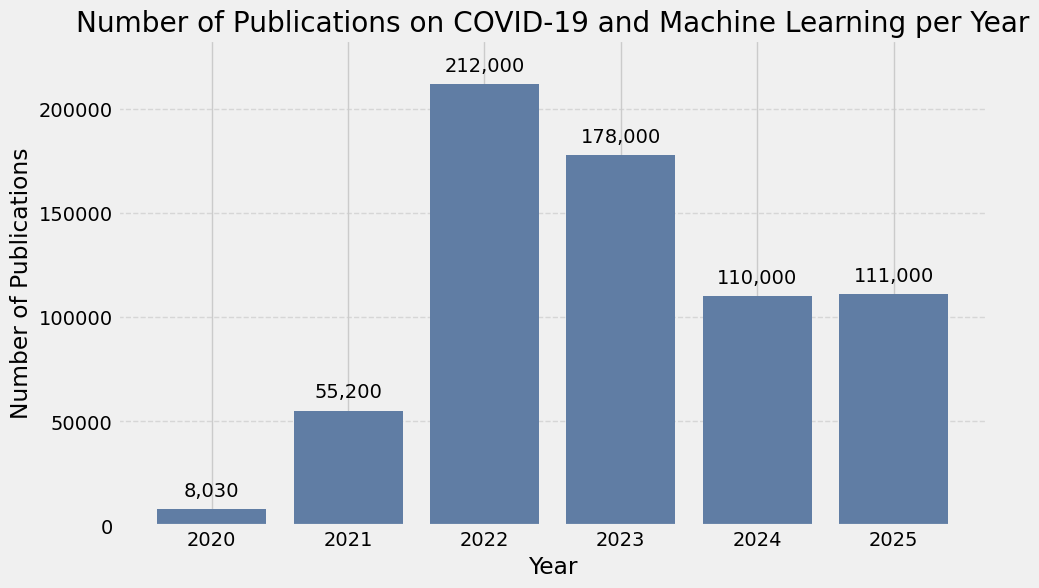

In [3]:
# Données corrigées par année (répcupérés sur Google Scholar)
years = [2020, 2021, 2022, 2023, 2024, 2025]
publications = [8030, 55200, 212000, 178000, 110000, 111000]

# Créer l'histogramme
plt.figure(figsize=(10,6))
plt.bar(years, publications, color="#607DA4")
plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.title('Number of Publications on COVID-19 and Machine Learning per Year')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Augmenter l'axe y pour plus de visibilité
plt.ylim(0, max(publications)*1.1)  # 20% au-dessus de la barre la plus haute

# Ajouter les valeurs au-dessus des barres
for i, pub in enumerate(publications):
    plt.text(years[i], pub + max(publications)*0.02, f"{pub:,}", ha='center', va='bottom')

plt.show()

## Pre-processing sur l'Europe

In [4]:
european_countries = [
    "France", "Germany", "Italy", "Spain", "Portugal", "Belgium", "Netherlands",
    "Luxembourg", "Switzerland", "Austria", "Poland",
    "Slovakia", "Hungary", "Slovenia", "Croatia", "Bosnia and Herzegovina",
    "Serbia", "Montenegro", "Greece", "Bulgaria", "Romania", "Moldova", "Ukraine", "Belarus", "Lithuania",
    "Latvia", "Estonia", "Norway", "Sweden", "Finland", "Denmark", "Iceland",
    "Ireland", "United Kingdom", "Cyprus"
]

df_europe = df[df["country"].isin(european_countries)]

#df_europe['date'] = pd.to_datetime(df_europe['date'])
#df_europe.set_index('date', inplace=True)

#df_europe = df_europe.resample('W').sum() # Resampling hebdomadaire

In [13]:
df_europe

,country,total_cases,new_cases,new_cases_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths,new_deaths,new_deaths_smoothed,...,population,population_density,median_age,life_expectancy,gdp_per_capita,extreme_poverty,diabetes_prevalence,handwashing_facilities,hospital_beds_per_thousand,human_development_index
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,Austria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9064633.0,109.847710,42.832001,81.295898,55867.183594,0.643974,4.6,NaN,7.27,NaN
2020-01-02,Austria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9064633.0,109.847710,42.832001,81.295898,55867.183594,0.643974,4.6,NaN,7.27,NaN
2020-01-03,Austria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9064633.0,109.847710,42.832001,81.295898,55867.183594,0.643974,4.6,NaN,7.27,NaN
2020-01-04,Austria,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,...,9064633.0,109.847710,42.832001,81.295898,55867.183594,0.643974,4.6,NaN,7.27,NaN
2020-01-05,Austria,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,...,9064633.0,109.847710,42.832001,81.295898,55867.183594,0.643974,4.6,NaN,7.27,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-30,United Kingdom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,68179267.0,281.814026,39.504002,81.074402,47587.167969,0.498311,6.3,NaN,2.46,NaN
2025-12-07,United Kingdom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,68179267.0,281.814026,39.504002,81.074402,47587.167969,0.498311,6.3,NaN,2.46,NaN
2025-12-14,United Kingdom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,68179267.0,281.814026,39.504002,81.074402,47587.167969,0.498311,6.3,NaN,2.46,NaN


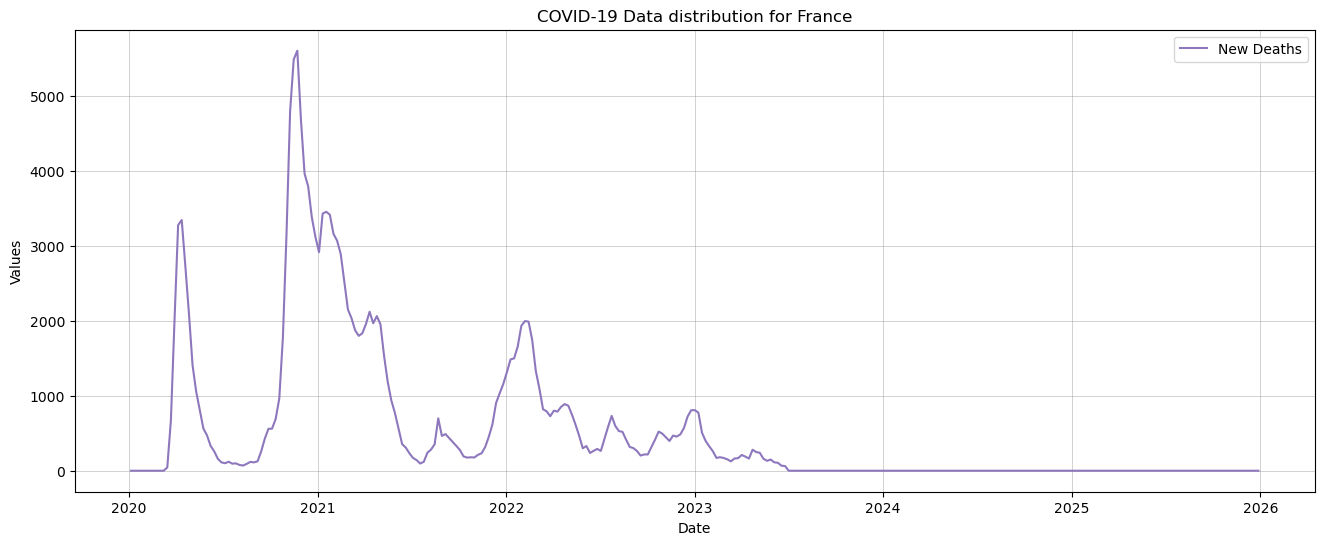

In [ ]:
#plot data france

df_france_non_filtered = df_europe[df_europe['country'] == 'France'].set_index('date').sort_index()
df_weekly_france = df_france_non_filtered.resample('W').sum()

feature = 'new_deaths'


plt.style.use('default') 
plt.figure(figsize=(16,6), facecolor="white")
plt.plot(df_weekly_france.index, df_weekly_france[feature], label='New Deaths', color='#8D77BD')
ax = plt.gca()
ax.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.5)
ax.set_xlabel('Date')
ax.set_ylabel('Values')
ax.set_title('COVID-19 Data distribution for France')
ax.legend()

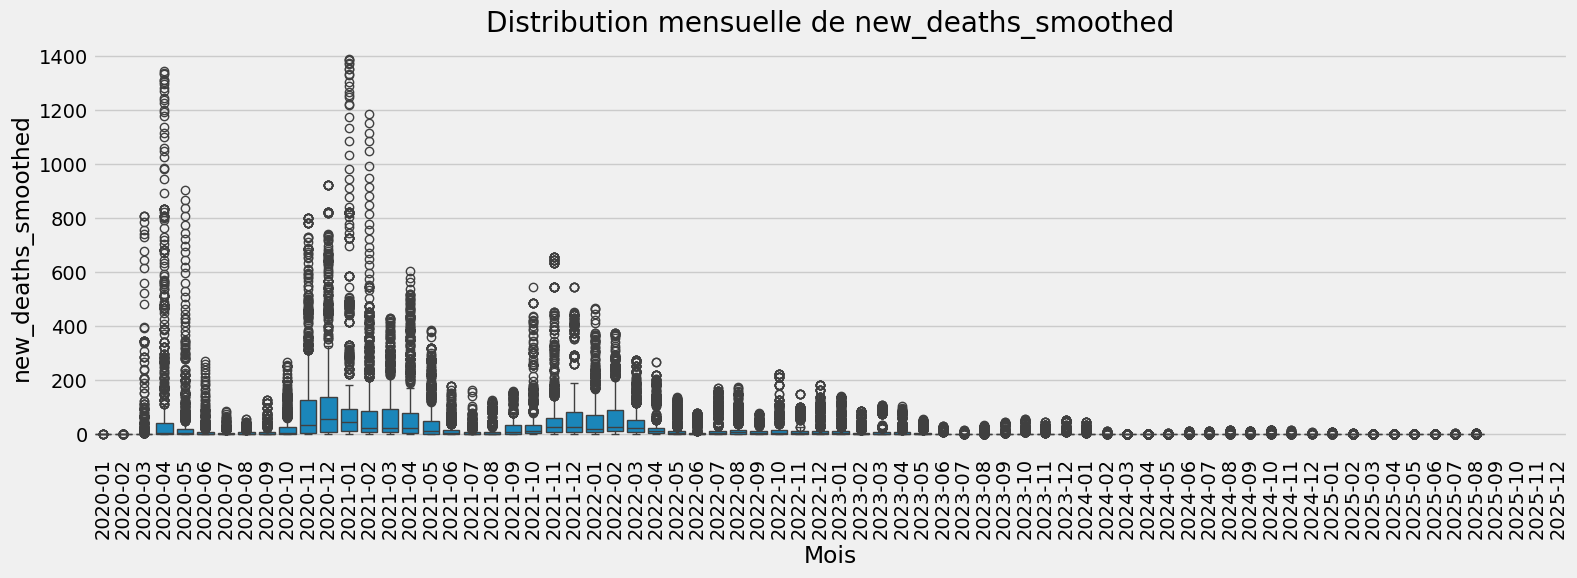

In [6]:
feature = 'new_deaths_smoothed'
df_europe['month'] = df_europe['date'].dt.to_period('M').astype(str)

plt.figure(figsize=(16,6))
sns.boxplot(x='month', y=feature, data=df_europe)
plt.xticks(rotation=90)
plt.title(f"Distribution mensuelle de {feature}")
plt.xlabel("Mois")
plt.ylabel(feature)
plt.tight_layout()
plt.show()

In [5]:
# Filtrer entre 01/02/2020 et fin 2022
df_europe = df_europe[(df_europe["date"] >= "2020-02-01") & (df_europe["date"] <= "2022-12-31")]

# Colonnes d’intérêt
features = [
    "new_deaths_smoothed", "new_cases_smoothed", "hosp_patients", "icu_patients",
    "stringency_index", "reproduction_rate", "new_tests_smoothed",
    "people_vaccinated", "people_fully_vaccinated", "total_boosters",
    "population_density", "population", "median_age", "life_expectancy",
    "gdp_per_capita", "diabetes_prevalence", "hospital_beds_per_thousand", "new_deaths",
    "new_cases", "total_cases", "total_deaths", "total_tests", "total_vaccinations", "new_tests", "new_vaccinations"
]

df_europe = df_europe[["country", "date"] + features]

### Imputation des NaN

In [6]:
nan_ratio = df_europe.isna().mean().sort_values(ascending=False)
print(nan_ratio)

total_boosters                0.693307
new_vaccinations              0.645929
people_fully_vaccinated       0.635439
people_vaccinated             0.618243
total_vaccinations            0.599142
icu_patients                  0.517264
hosp_patients                 0.438954
new_tests                     0.398444
total_tests                   0.384279
new_tests_smoothed            0.280563
reproduction_rate             0.040107
stringency_index              0.028571
hospital_beds_per_thousand    0.000000
total_deaths                  0.000000
total_cases                   0.000000
new_cases                     0.000000
new_deaths                    0.000000
country                       0.000000
diabetes_prevalence           0.000000
gdp_per_capita                0.000000
life_expectancy               0.000000
median_age                    0.000000
date                          0.000000
population_density            0.000000
new_cases_smoothed            0.000000
new_deaths_smoothed      

In [7]:
# 1. Vaccins et boosters
for col in ["people_vaccinated", "people_fully_vaccinated", "total_boosters"]:
    df_europe[col] = df_europe[col].fillna(0).interpolate()

# Hosp / ICU patients : interpolation + ffill/bfill + mean par pays
for col in ["hosp_patients", "icu_patients"]:
    # interpolation et propagation
    df_europe[col] = df_europe.groupby("country")[col].transform(
        lambda x: x.interpolate().fillna(method="ffill").fillna(method="bfill")
    )
    # Si il reste encore des NaN (tous les jours NaN pour ce pays), remplacer par moyenne globale
    df_europe[col] = df_europe[col].fillna(df_europe[col].mean())

# Autres variables temporelles : interpolation + ffill/bfill + mean par pays
for col in ["new_tests_smoothed", "reproduction_rate", "stringency_index", "total_vaccinations", "total_tests", "new_tests", "new_vaccinations"]:
    # interpolation et propagation
    df_europe[col] = df_europe.groupby("country")[col].transform(
        lambda x: x.interpolate().fillna(method="ffill").fillna(method="bfill")
    )
    # Si il reste encore des NaN (pays sans données du tout), remplacer par moyenne globale
    df_europe[col] = df_europe[col].fillna(df_europe[col].mean())



### Check

In [7]:
df_europe.isna().sum()

country                       0
date                          0
new_deaths_smoothed           0
new_cases_smoothed            0
hosp_patients                 0
icu_patients                  0
stringency_index              0
reproduction_rate             0
new_tests_smoothed            0
people_vaccinated             0
people_fully_vaccinated       0
total_boosters                0
population_density            0
population                    0
median_age                    0
life_expectancy               0
gdp_per_capita                0
diabetes_prevalence           0
hospital_beds_per_thousand    0
new_deaths                    0
new_cases                     0
total_cases                   0
total_deaths                  0
total_tests                   0
total_vaccinations            0
new_tests                     0
new_vaccinations              0
dtype: int64

In [9]:
df_europe

,country,date,new_deaths_smoothed,new_cases_smoothed,hosp_patients,icu_patients,stringency_index,reproduction_rate,new_tests_smoothed,people_vaccinated,...,diabetes_prevalence,hospital_beds_per_thousand,new_deaths,new_cases,total_cases,total_deaths,total_tests,total_vaccinations,new_tests,new_vaccinations
31008,Austria,2020-02-01,0.00000,0.0000,1071.0,215.0,0.00,2.8046,14846.0,0.0,...,4.6,7.27,0.0,0.0,0.0,0.0,16834.0,31790.0,75356.0,42766.274765
31009,Austria,2020-02-02,0.00000,0.0000,1071.0,215.0,0.00,2.8046,14846.0,0.0,...,4.6,7.27,0.0,0.0,0.0,0.0,16834.0,31790.0,75356.0,42766.274765
31010,Austria,2020-02-03,0.00000,0.0000,1071.0,215.0,0.00,2.8046,14846.0,0.0,...,4.6,7.27,0.0,0.0,0.0,0.0,16834.0,31790.0,75356.0,42766.274765
31011,Austria,2020-02-04,0.00000,0.0000,1071.0,215.0,0.00,2.8046,14846.0,0.0,...,4.6,7.27,0.0,0.0,0.0,0.0,16834.0,31790.0,75356.0,42766.274765
31012,Austria,2020-02-05,0.00000,0.0000,1071.0,215.0,0.00,2.8046,14846.0,0.0,...,4.6,7.27,0.0,0.0,0.0,0.0,16834.0,31790.0,75356.0,42766.274765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489373,United Kingdom,2022-12-27,121.00000,6564.2856,11306.0,175.0,5.56,0.3378,259329.0,0.0,...,6.3,2.46,131.0,3694.0,24166863.0,215621.0,503270347.0,151248820.0,245960.0,5992.000000
489374,United Kingdom,2022-12-28,123.00000,5975.2856,11538.0,175.0,5.56,0.3026,259329.0,0.0,...,6.3,2.46,129.0,4950.0,24171813.0,215750.0,503270347.0,151248820.0,245960.0,5992.000000
489375,United Kingdom,2022-12-29,127.14286,5685.8570,11670.0,175.0,5.56,0.2730,259329.0,0.0,...,6.3,2.46,142.0,6605.0,24178418.0,215892.0,503270347.0,151248820.0,245960.0,5992.000000
489376,United Kingdom,2022-12-30,130.57143,5774.0000,11722.0,175.0,5.56,0.2776,259329.0,0.0,...,6.3,2.46,134.0,8419.0,24186837.0,216026.0,503270347.0,151248820.0,245960.0,5992.000000


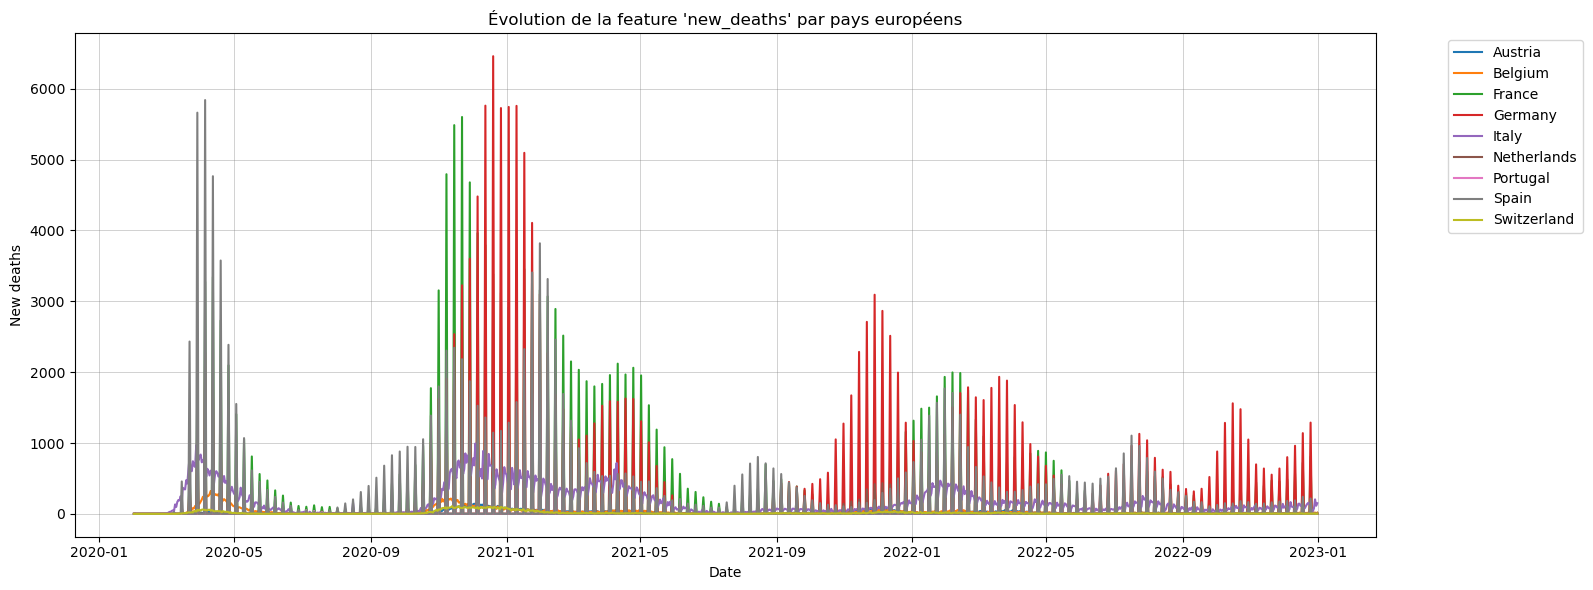

In [24]:
data = df_europe[df_europe['country'].isin([
    'France', 'Germany', 'Italy', 'Spain', 'Portugal',
    'Belgium', 'Netherlands', 'Austria', 'Switzerland'
])]

data['date'] = pd.to_datetime(data['date'])

plt.style.use('default')
plt.figure(figsize=(16, 6), facecolor="white")

# Boucle sur chaque pays pour tracer sa courbe
for country in data['country'].unique():
    subset = data[data['country'] == country]
    plt.plot(subset['date'], subset['new_deaths'], label=country)
ax = plt.gca()
ax.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.5)
ax.set_xlabel('Date')
ax.set_ylabel('New deaths')
ax.set_title("Évolution de la feature 'new_deaths' par pays européens")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [25]:
df_europe

,country,date,new_deaths_smoothed,new_cases_smoothed,hosp_patients,icu_patients,stringency_index,reproduction_rate,new_tests_smoothed,people_vaccinated,...,diabetes_prevalence,hospital_beds_per_thousand,new_deaths,new_cases,total_cases,total_deaths,total_tests,total_vaccinations,new_tests,new_vaccinations
31008,Austria,2020-02-01,0.00000,0.0000,1071.0,215.0,0.00,2.8046,14846.0,0.0,...,4.6,7.27,0.0,0.0,0.0,0.0,16834.0,31790.0,75356.0,42766.274765
31009,Austria,2020-02-02,0.00000,0.0000,1071.0,215.0,0.00,2.8046,14846.0,0.0,...,4.6,7.27,0.0,0.0,0.0,0.0,16834.0,31790.0,75356.0,42766.274765
31010,Austria,2020-02-03,0.00000,0.0000,1071.0,215.0,0.00,2.8046,14846.0,0.0,...,4.6,7.27,0.0,0.0,0.0,0.0,16834.0,31790.0,75356.0,42766.274765
31011,Austria,2020-02-04,0.00000,0.0000,1071.0,215.0,0.00,2.8046,14846.0,0.0,...,4.6,7.27,0.0,0.0,0.0,0.0,16834.0,31790.0,75356.0,42766.274765
31012,Austria,2020-02-05,0.00000,0.0000,1071.0,215.0,0.00,2.8046,14846.0,0.0,...,4.6,7.27,0.0,0.0,0.0,0.0,16834.0,31790.0,75356.0,42766.274765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489373,United Kingdom,2022-12-27,121.00000,6564.2856,11306.0,175.0,5.56,0.3378,259329.0,0.0,...,6.3,2.46,131.0,3694.0,24166863.0,215621.0,503270347.0,151248820.0,245960.0,5992.000000
489374,United Kingdom,2022-12-28,123.00000,5975.2856,11538.0,175.0,5.56,0.3026,259329.0,0.0,...,6.3,2.46,129.0,4950.0,24171813.0,215750.0,503270347.0,151248820.0,245960.0,5992.000000
489375,United Kingdom,2022-12-29,127.14286,5685.8570,11670.0,175.0,5.56,0.2730,259329.0,0.0,...,6.3,2.46,142.0,6605.0,24178418.0,215892.0,503270347.0,151248820.0,245960.0,5992.000000
489376,United Kingdom,2022-12-30,130.57143,5774.0000,11722.0,175.0,5.56,0.2776,259329.0,0.0,...,6.3,2.46,134.0,8419.0,24186837.0,216026.0,503270347.0,151248820.0,245960.0,5992.000000


## Pour l'europe

In [8]:
def feature_processing(country):

    df = df_europe[df_europe['country'] == country].copy()
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')

    # 2. Définir les colonnes par type
    cols_sum = ["new_cases", "new_deaths", "new_tests", "new_vaccinations"]
    cols_mean = ["hosp_patients", "icu_patients", "stringency_index", "reproduction_rate",]
    cols_last = ["total_cases", "total_tests", "total_vaccinations",
                "people_vaccinated", "total_boosters"]

    # 3. Calculer les agrégations
    weekly_sum = df[cols_sum].resample("W-SUN").sum()
    weekly_mean = df[cols_mean].resample("W-SUN").mean()
    weekly_last = df[cols_last].resample("W-SUN").last() 

    # 4. Combiner tout
    df_weekly = pd.concat([weekly_sum, weekly_mean, weekly_last], axis=1)
    df_weekly = df_weekly.iloc[:-1, :]
    df_weekly = df_weekly.loc["2021-10":"2022-12"]

    return df_weekly

#df_weekly_europe = feature_processing(df_europe)

#df_weekly_europe.to_csv('../data/europe_weekly.csv')


In [76]:
df_all

,date,new_cases,new_deaths,new_tests,new_vaccinations,hosp_patients,icu_patients,stringency_index,reproduction_rate,total_cases,total_tests,total_vaccinations,people_vaccinated,total_boosters,country
0,2020-09-06,50197.0,126.0,1153183.0,4977.0,4629.428571,448.857143,48.015714,1.327271,180767.0,8194778.0,616.0,0.0,0.0,France
1,2020-09-13,61432.0,258.0,1365371.0,4977.0,5061.857143,606.428571,48.610000,1.256357,242199.0,9560149.0,616.0,0.0,0.0,France
2,2020-09-20,73481.0,429.0,1401487.0,4977.0,5630.428571,789.571429,48.610000,1.221043,315680.0,10961636.0,616.0,0.0,0.0,France
3,2020-09-27,72509.0,559.0,1185597.0,4977.0,5971.142857,1028.714286,47.818571,1.182786,388189.0,12147233.0,616.0,0.0,0.0,France
4,2020-10-04,74819.0,561.0,1113751.0,4977.0,6647.000000,1248.714286,49.540000,1.154114,463008.0,13260984.0,616.0,0.0,0.0,France
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4230,2022-11-27,4214.0,8.0,470442.0,10059.0,75.836735,1.122449,11.110000,0.661271,614237.0,29501771.0,1796692.4,0.0,0.0,Cyprus
4231,2022-12-04,4011.0,11.0,470442.0,10059.0,90.795918,2.000000,11.110000,0.783886,618248.0,29501771.0,1796940.2,0.0,0.0,Cyprus
4232,2022-12-11,3854.0,5.0,470442.0,10059.0,91.795918,2.755102,11.110000,0.903500,622102.0,29501771.0,1797188.0,0.0,0.0,Cyprus
4233,2022-12-18,3460.0,8.0,470442.0,10059.0,78.591837,2.244898,11.110000,1.035171,625562.0,29501771.0,1797435.8,0.0,0.0,Cyprus


## pays non inlcus : United Kingdom, Italy, Croatia

In [9]:
european_countries = [
    "France", "Germany", "Spain", "Portugal", "Belgium", "Netherlands",
    "Luxembourg", "Switzerland", "Austria", "Poland",
    "Slovakia", "Hungary", "Slovenia", "Bosnia and Herzegovina",
    "Serbia", "Montenegro", "Greece", "Bulgaria", "Romania", "Moldova", "Ukraine", "Belarus", "Lithuania",
    "Latvia", "Estonia", "Norway", "Sweden", "Finland", "Denmark", "Iceland",
    "Ireland", "Cyprus"
]

df_all = []
countries_more_50 = []
countries_less_50 = []

for country in european_countries:
    df_weekly_country = feature_processing(country)
    # transformer l'index date en colonne et forcer le type datetime
    df_weekly_country = df_weekly_country.reset_index()
    df_weekly_country['date'] = pd.to_datetime(df_weekly_country['date'])
    df_weekly_country["country"] = country  # ajoute la colonne "country"

    # si pas de données
    if df_weekly_country.empty:
        print(f"{country} : pas de données hebdomadaires.")
        countries_less_50.append(country)
        continue

    series = df_weekly_country["new_deaths"]

    # Vérification des décès
    if (series > 50).all():
        print(f"{country} : toutes les semaines ont > 50 morts.")
        countries_more_50.append(country)
    elif (series > 50).any():
        print(f"{country} : au moins une semaine avec > 50 morts.")
        countries_more_50.append(country)
    else:
        print(f"{country} : aucune semaine avec > 50 morts.")
        countries_less_50.append(country)
        continue  # on ne garde pas ce pays

    # Ajouter le DataFrame seulement si le pays a au moins une semaine > 50 morts
    df_all.append(df_weekly_country)
    print(f"{country} ajouté au DataFrame global.")

# Concaténer tous les DataFrames retenus
if df_all:
    df_all = pd.concat(df_all, axis=0, ignore_index=True)
else:
    df_all = pd.DataFrame()  # au cas où aucun pays n'est retenu

df_all.to_csv('../data/europe_weekly_selected.csv')

print("\nPays conservés :", countries_more_50)
print("\nPays exclus (< 50 morts par semaine) :", countries_less_50)


France : toutes les semaines ont > 50 morts.
France ajouté au DataFrame global.
Germany : toutes les semaines ont > 50 morts.
Germany ajouté au DataFrame global.
Spain : toutes les semaines ont > 50 morts.
Spain ajouté au DataFrame global.
Portugal : au moins une semaine avec > 50 morts.
Portugal ajouté au DataFrame global.
Belgium : au moins une semaine avec > 50 morts.
Belgium ajouté au DataFrame global.
Netherlands : au moins une semaine avec > 50 morts.
Netherlands ajouté au DataFrame global.
Luxembourg : aucune semaine avec > 50 morts.
Switzerland : au moins une semaine avec > 50 morts.
Switzerland ajouté au DataFrame global.
Austria : au moins une semaine avec > 50 morts.
Austria ajouté au DataFrame global.
Poland : au moins une semaine avec > 50 morts.
Poland ajouté au DataFrame global.
Slovakia : au moins une semaine avec > 50 morts.
Slovakia ajouté au DataFrame global.
Hungary : au moins une semaine avec > 50 morts.
Hungary ajouté au DataFrame global.
Slovenia : au moins une s

In [12]:
pays = df_all["country"].unique()
print(len(pays))

30


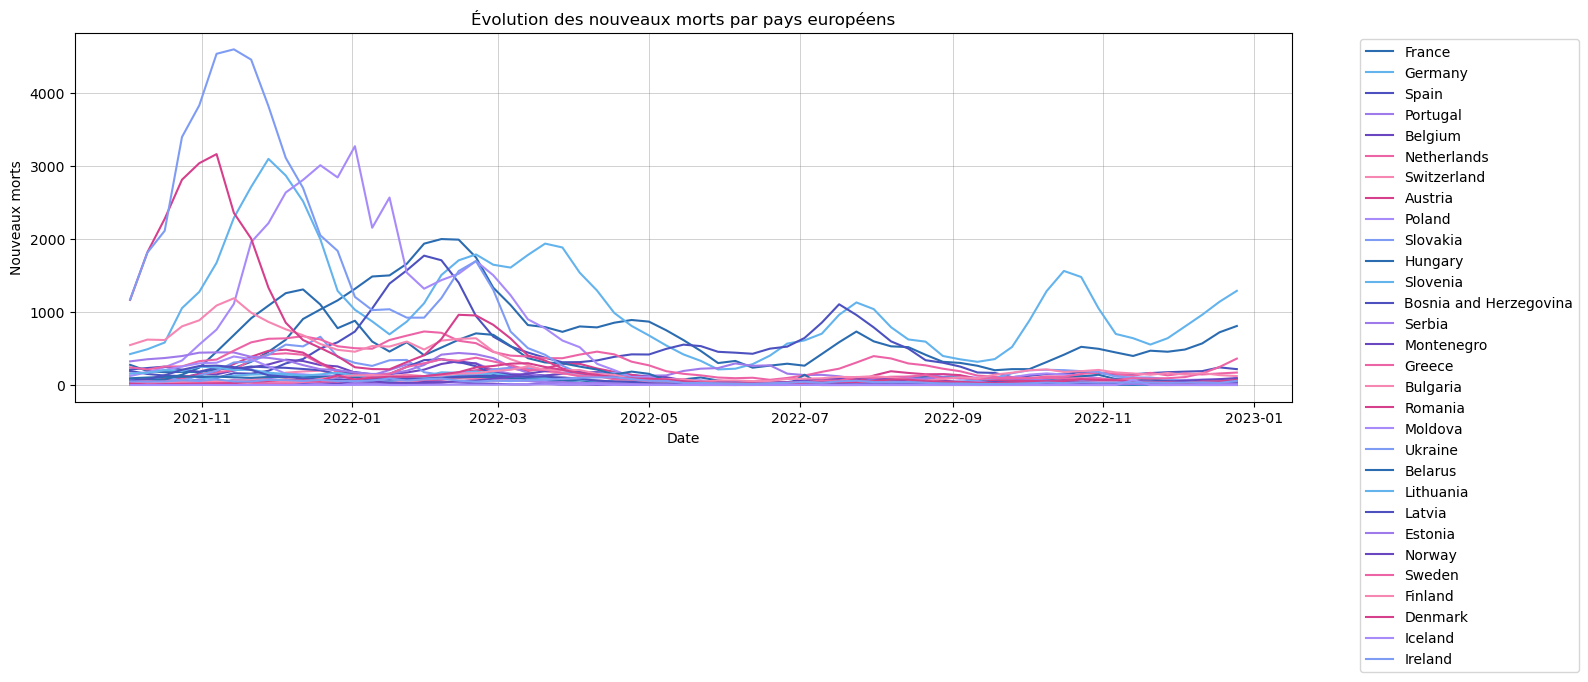

In [13]:

palette = [
    "#2B6CB0",  # bleu profond
    "#63B3ED",  # bleu ciel
    "#4C51BF",  # violet
    "#9F7AEA",  # violet clair
    "#6B46C1",  # violet soutenu
    "#ED64A6",  # rose vif
    "#F687B3",  # rose clair
    "#D53F8C",  # fuchsia
    "#A78BFA",  # lavande
    "#7F9CF5"   # bleu lavande
]

sns.set_palette(palette)

plt.style.use('default')
plt.figure(figsize=(16, 6), facecolor="white")

countries = df_all['country'].unique()

for i, country in enumerate(countries):
    subset = df_all[df_all['country'] == country]
    color = palette[i % len(palette)]  # cycle si plus de pays que de couleurs
    plt.plot(subset['date'], subset['new_deaths'], label=country, color=color)

plt.title("Évolution des nouveaux morts par pays européens")
plt.xlabel("Date")
plt.ylabel("Nouveaux morts")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # légende à droite
plt.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.5)
plt.tight_layout()
plt.show()

## agrégation pour tous les pays de l'europe

In [14]:
# Agréger par semaine (moyenne de tous les pays européens)
df_europe_weekly_mean_selected = (
    df_all
    .groupby('date')                      # on regroupe toutes les lignes ayant la même semaine
    .mean(numeric_only=True)              # moyenne de toutes les colonnes numériques
    .reset_index()                        # on remet la date comme colonne normale
)

df_europe_weekly_mean_selected.to_csv('../data/europe_weekly_mean_selected.csv')


In [15]:
df_europe_weekly_mean_selected

,date,new_cases,new_deaths,new_tests,new_vaccinations,hosp_patients,icu_patients,stringency_index,reproduction_rate,total_cases,total_tests,total_vaccinations,people_vaccinated,total_boosters
0,2021-10-03,15468.700000,192.133333,429116.207280,268453.875450,2331.165230,361.768439,39.068422,1.077061,1.205451e+06,2.399180e+07,1.713829e+07,7.505130e+06,8.678950e+04
1,2021-10-10,17315.233333,240.466667,415456.941836,314513.642574,2429.512849,359.239868,38.253707,1.108272,1.222767e+06,2.439624e+07,1.735478e+07,7.014316e+06,1.586957e+05
2,2021-10-17,19725.566667,279.466667,421425.623058,265930.558260,2566.155706,362.220820,38.051660,1.156062,1.242492e+06,2.479280e+07,1.755093e+07,7.722368e+06,1.987233e+05
3,2021-10-24,26322.266667,372.133333,415733.514941,299536.051071,2710.898563,374.292249,38.292136,1.223190,1.268814e+06,2.519745e+07,1.779259e+07,7.947276e+06,2.705233e+05
4,2021-10-31,31128.566667,431.766667,408923.741235,351425.109894,2873.396182,396.364471,38.562231,1.222964,1.299943e+06,2.561304e+07,1.807185e+07,6.413510e+06,3.065621e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,2022-11-27,21174.300000,75.400000,211010.462160,163577.437672,2067.489039,220.868439,11.806945,0.951885,5.326098e+06,4.272507e+07,2.844790e+07,5.319093e+06,4.860123e+06
61,2022-12-04,25069.766667,82.066667,211010.462160,161955.982117,2129.381896,224.220820,11.621898,0.978504,5.351168e+06,4.272507e+07,2.851034e+07,6.411823e+06,5.837130e+06
62,2022-12-11,27342.866667,95.633333,211010.462160,165405.271005,2240.869992,230.563677,11.410469,0.961810,5.378511e+06,4.272507e+07,2.856698e+07,6.080705e+06,5.415688e+06
63,2022-12-18,26935.666667,114.066667,211010.462160,166560.048783,2371.365230,241.801773,11.384041,0.903719,5.405446e+06,4.272507e+07,2.862054e+07,5.945847e+06,5.414828e+06


In [16]:
# Créer des lags et un horizon de forecast

def feature_engineering(df):
    
    # Créer des lags pour la target
    df["lag_1"] = df["new_deaths"].shift(1)
    df["lag_2"] = df["new_deaths"].shift(2)
    df["lag_3"] = df["new_deaths"].shift(3)
    df["lag_7"] = df["new_deaths"].shift(7)
    df["lag_14"] = df["new_deaths"].shift(14)

    # Moyennes et écarts-types roulants
    df["rolling_mean_3"] = df["new_deaths"].rolling(window=3).mean()
    df["rolling_std_3"] = df["new_deaths"].rolling(window=3).std()
    df["rolling_mean_7"] = df["new_deaths"].rolling(window=7).mean()
    df["rolling_std_7"] = df["new_deaths"].rolling(window=7).std()

    # Horizon de forecast (1 jour dans le futur)
    df["target_t_plus"] = df["new_deaths"].shift(-1)
    df["date_t_plus"] = df.index.to_series().shift(-1)
    return df

#df_europe_weekly_mean['date'] = pd.to_datetime(df_europe_weekly_mean['date'])
#df_europe_weekly_mean = df_europe_weekly_mean.set_index('date')

df_europe_mean_lags = feature_engineering(df_europe_weekly_mean_selected)
df_europe_mean_lags = df_europe_mean_lags.dropna()
df_europe_mean_lags.to_csv('../data/df_europe_mean_lags_selected.csv')

# X = df_europe_mean_lags.drop(columns=["date_t_plus","target_t_plus", "new_deaths"])
# y = df_europe_mean_lags[["date_t_plus", "target_t_plus"]]


In [ ]:
from life import path
if graduated == True:
path.change_direction(from_="Biologie", to="Informatique")


## Pour la France

In [10]:
def feature_processing(country='France'):
    # 1. Filtrer la France
    df = df_europe[df_europe['country'] == country].copy()
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')

    # 2. Définir les colonnes par type
    cols_sum = ["new_cases", "new_deaths", "new_tests", "new_vaccinations"]
    cols_mean = ["hosp_patients", "icu_patients", "stringency_index", "reproduction_rate",]
    cols_last = ["total_cases", "total_tests", "total_vaccinations",
                "people_vaccinated", "total_boosters"]

    # 3. Calculer les agrégations
    weekly_sum = df[cols_sum].resample("W-SUN").sum()
    weekly_mean = df[cols_mean].resample("W-SUN").mean()
    weekly_last = df[cols_last].resample("W-SUN").last()

    # 4. Combiner tout
    df_weekly = pd.concat([weekly_sum, weekly_mean, weekly_last], axis=1)
    df_weekly = df_weekly.iloc[:-1, :]
    df_weekly = df_weekly.loc["2020-09":"2022-12"]

    return df_weekly

df_weekly_france = feature_processing('France')

df_weekly_france.to_csv('../data/france_weekly.csv')


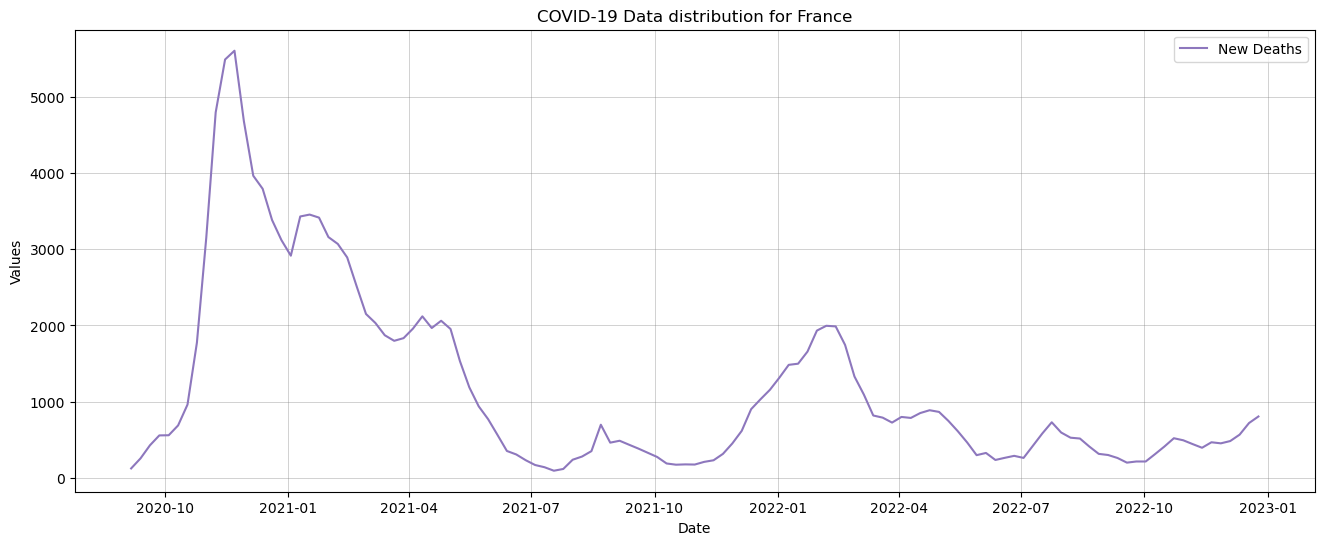

In [9]:
#plot data france
plt.style.use('default') 
plt.figure(figsize=(16,6), facecolor="white")
plt.plot(df_weekly_france.index, df_weekly_france['new_deaths'], label='New Deaths', color='#8D77BD')
ax = plt.gca()
ax.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.5)
ax.set_xlabel('Date')
ax.set_ylabel('Values')
ax.set_title('COVID-19 Data distribution for France')
ax.legend()

In [11]:
# Créer des lags et un horizon de forecast

def feature_engineering(df):
    # Créer des lags pour la target
    df["lag_1"] = df["new_deaths"].shift(1)
    df["lag_2"] = df["new_deaths"].shift(2)
    df["lag_3"] = df["new_deaths"].shift(3)
    df["lag_7"] = df["new_deaths"].shift(7)
    df["lag_14"] = df["new_deaths"].shift(14)

    # Moyennes et écarts-types roulants
    df["rolling_mean_3"] = df["new_deaths"].rolling(window=3).mean()
    df["rolling_std_3"] = df["new_deaths"].rolling(window=3).std()
    df["rolling_mean_7"] = df["new_deaths"].rolling(window=7).mean()
    df["rolling_std_7"] = df["new_deaths"].rolling(window=7).std()

    # Variables temporelles
    df["day_of_week"] = df.index.dayofweek
    df["months"] = df.index.month

    # Horizon de forecast (1 jour dans le futur)
    df["target_t_plus"] = df["new_deaths"].shift(-1)
    df["date_t_plus"] = df.index.shift(-1)
    return df

df_france_augmented = feature_engineering(df_weekly_france)

df_france_augmented.to_csv('../data/df_france_with_lags.csv')

# Supprimer les premier lignes qui ont des NaN dues à la création des lags
df_model = df_france_augmented.dropna()

X = df_model.drop(columns=["date_t_plus","target_t_plus", "new_deaths"])
y = df_model[["date_t_plus", "target_t_plus"]]


In [11]:
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

X_train_lags = X_train[["lag_1", "lag_2", "lag_3", "lag_7", "lag_14", "rolling_mean_3", "rolling_std_3", "rolling_mean_7", "rolling_std_7", "day_of_week", "months"]]
X_test_lags = X_test[["lag_1", "lag_2", "lag_3", "lag_7", "lag_14", "rolling_mean_3", "rolling_std_3", "rolling_mean_7", "rolling_std_7", "day_of_week", "months"]]

In [12]:
def evaluate_model(model, X_train, y_train, X_test, y_test, evalutation_only = False, ax = None, rmse=False):
    """
    Evaluate a regression model using time series cross-validation, and report performance on a test set.
    
    Parameters:
    - model: sklearn-like estimator
    - X_train, X_test: pd.DataFrame, features
    - y_train, y_test: pd.DataFrame, target (must contain 'target_t_plus' and optionally 'date_t_plus')
    """
    model_name = model.__class__.__name__

    if not evalutation_only:
        # Cross-validation on training data
        tscv = TimeSeriesSplit(n_splits=3)
        scores = cross_val_score(
            model, X_train, y_train['target_t_plus'],
            cv=tscv, scoring='neg_root_mean_squared_error'
        )

        rmse_scores = -scores
        print(f"{model_name} - RMSE for each split: {rmse_scores}")
        print(f"{model_name} - Mean RMSE: {rmse_scores.mean():.4f}")

        # Fit model and predict on test set
        model.fit(X_train, y_train['target_t_plus'])
    y_pred = model.predict(X_test)

    # Evaluation on test set
    rmse_test = root_mean_squared_error(y_test['target_t_plus'], y_pred)
    if not evalutation_only:
        print(f"{model_name} Test Set -> RMSE: {rmse_test:.4f}")
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 7), facecolor="white")

    ax.plot(y_test['date_t_plus'], y_test['target_t_plus'], label='Actual', color='#8D77BD', linewidth=1.2)
    ax.plot(y_test['date_t_plus'], y_pred, label='Predicted', color="#B93B6D", linewidth=1.2)
    ax.set_xlabel('Date')
    ax.set_ylabel('New Deaths')
    ax.set_title(f'{model_name} - RMSE: {rmse_test:.2f}', fontsize=10)
    ax.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.5)
    ax.tick_params(axis='x', labelrotation=45)
    
    if ax is None:
        ax.legend()
        plt.tight_layout()
        plt.show()

    # Feature importances (if available)
    if hasattr(model, "feature_importances_") and not evalutation_only:
        feature_importances = model.feature_importances_
        coef_df = pd.DataFrame({
            "Feature": X_train.columns,
            "Importance": feature_importances
        }).sort_values(by="Importance", ascending=True)

        fig, ax = plt.subplots(figsize=(10, 8))
        ax.barh(coef_df["Feature"], coef_df["Importance"], color="#B93BAC")
        ax.set_xlabel("Importance")
        ax.set_title(f"{model_name} - Feature Importance for Predicting COVID Deaths")
        ax.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.5)

        # Add values to bars
        for i, (imp, feat) in enumerate(zip(coef_df["Importance"], coef_df["Feature"])):
            ax.text(imp + 0.001, i, f"{imp:.3f}", va="center")

        plt.tight_layout()
        plt.show()
    
    return model if not rmse else rmse_test

RandomForestRegressor - RMSE for each split: [1606.14886165  711.92871255  522.39352657]
RandomForestRegressor - Mean RMSE: 946.8237
RandomForestRegressor Test Set -> RMSE: 106.1792


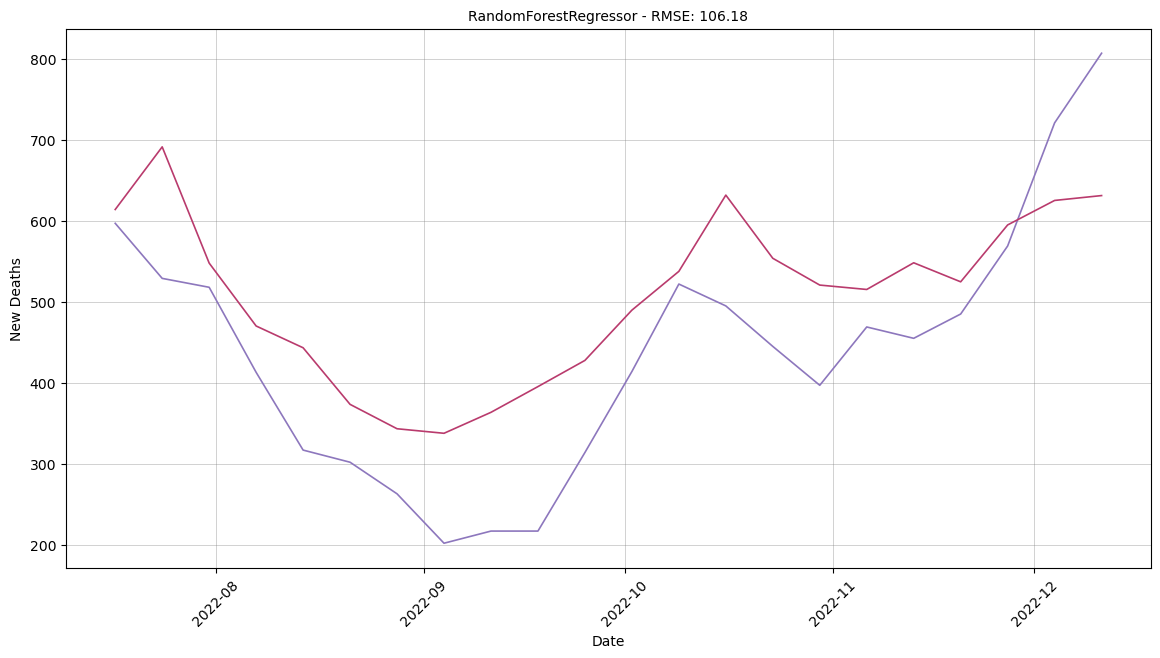

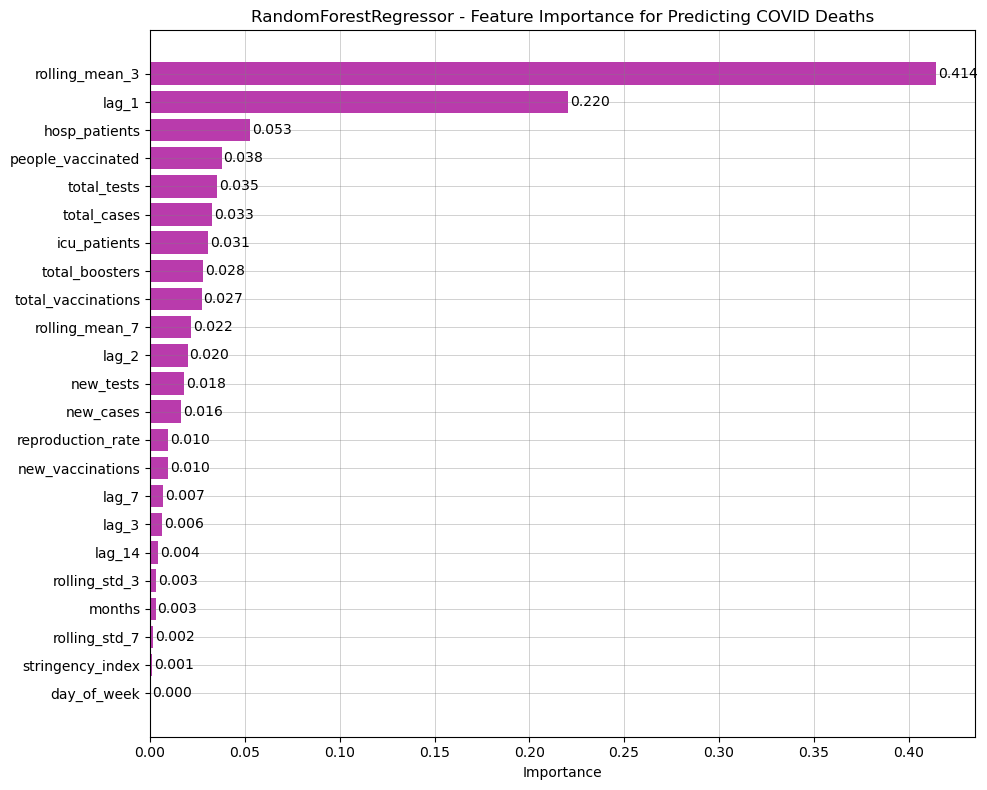

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [13]:
evaluate_model(RandomForestRegressor(random_state=42), X_train, y_train, X_test, y_test)

## avec que les lags

RandomForestRegressor - RMSE for each split: [1535.14173866  650.27265023  282.18226818]
RandomForestRegressor - Mean RMSE: 822.5322
RandomForestRegressor Test Set -> RMSE: 116.5661


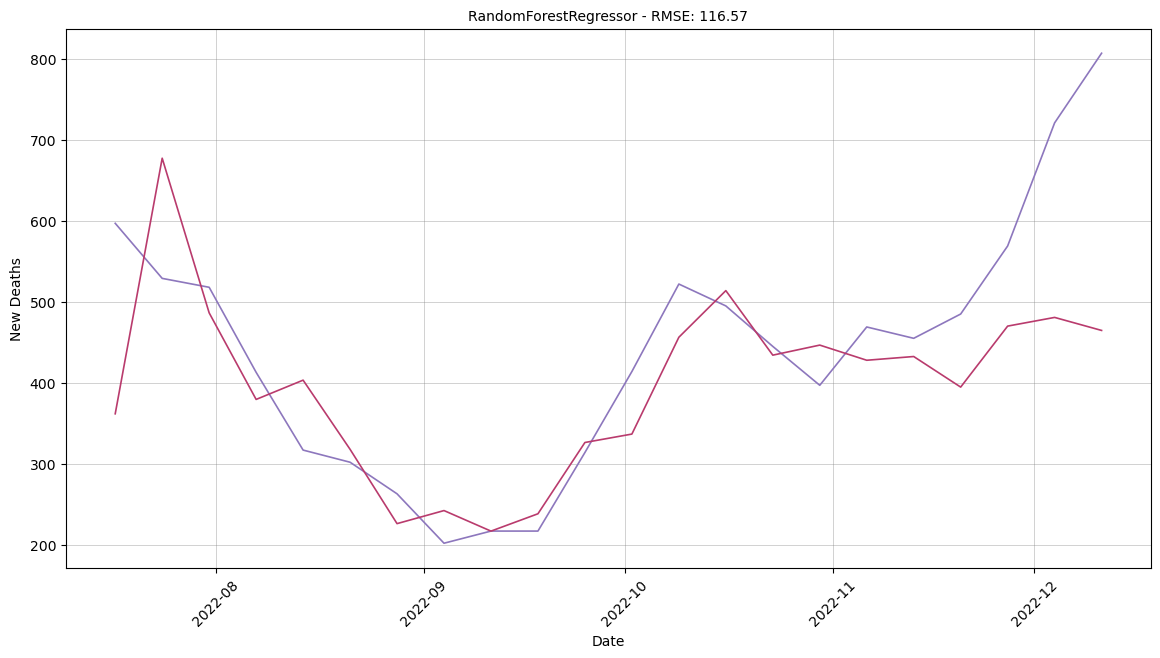

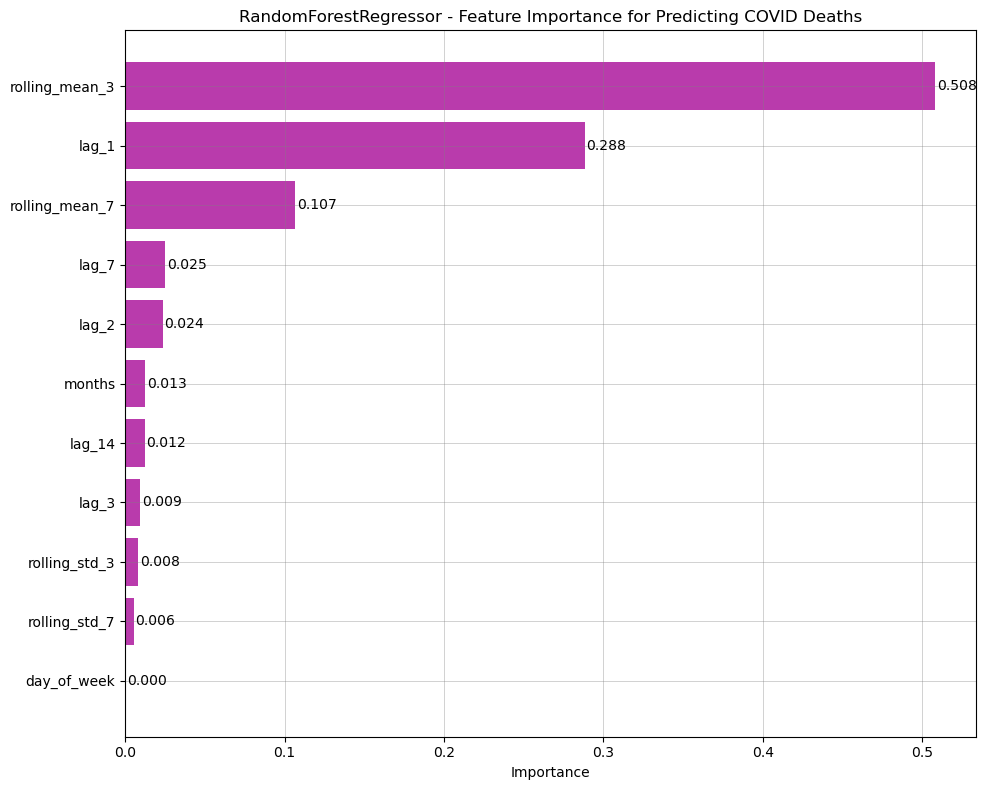

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [14]:
evaluate_model(RandomForestRegressor(random_state=42), X_train_lags, y_train, X_test_lags, y_test)

## XGBoost

XGBRegressor - RMSE for each split: [1676.8400683   455.21547334  971.35568374]
XGBRegressor - Mean RMSE: 1034.4704
XGBRegressor Test Set -> RMSE: 221.5520


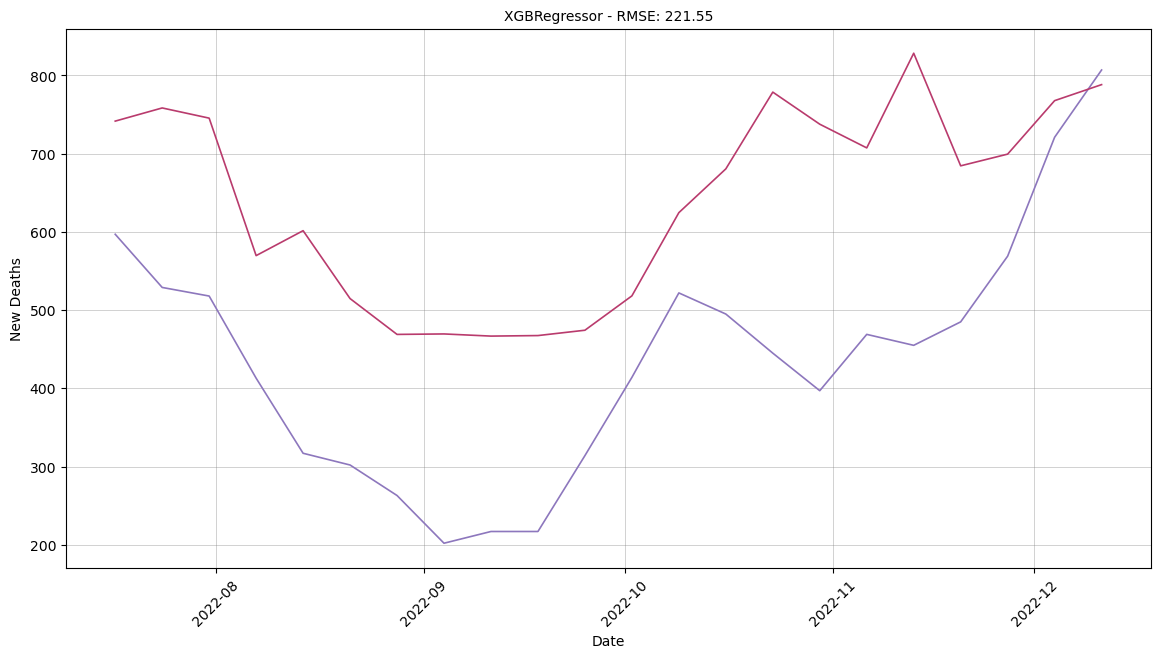

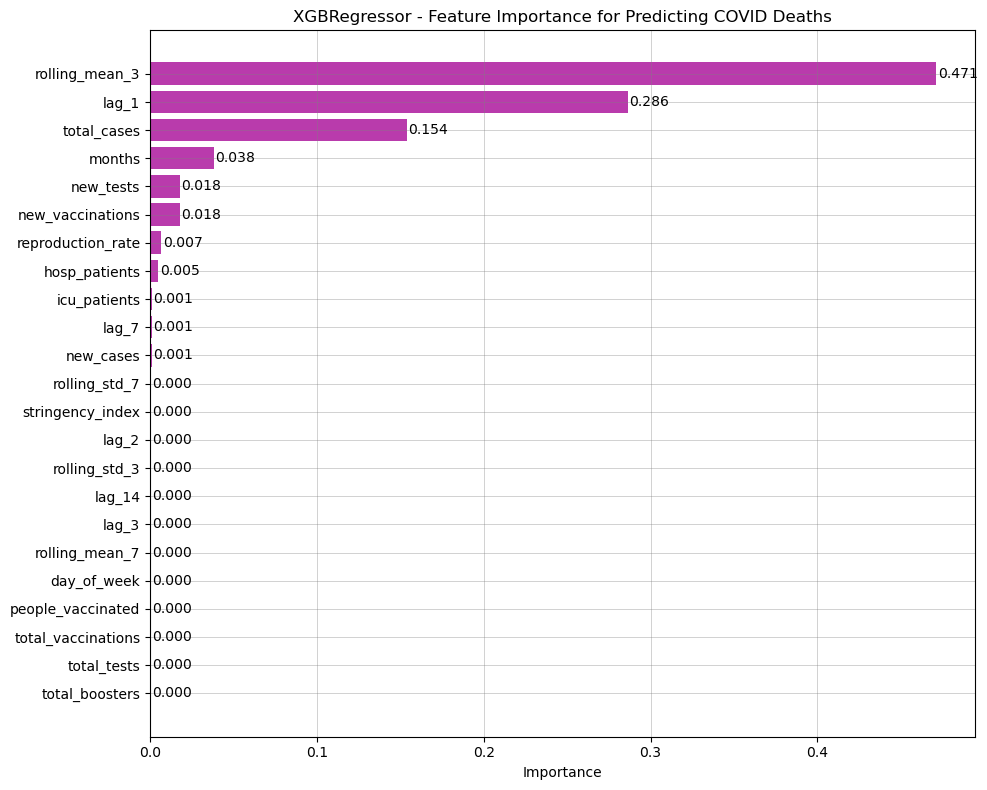

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [15]:
evaluate_model(xgb.XGBRegressor(random_state=42), X_train, y_train, X_test, y_test)

XGBRegressor - RMSE for each split: [1471.02359533  599.54924458  353.1741181 ]
XGBRegressor - Mean RMSE: 807.9157
XGBRegressor Test Set -> RMSE: 94.4661


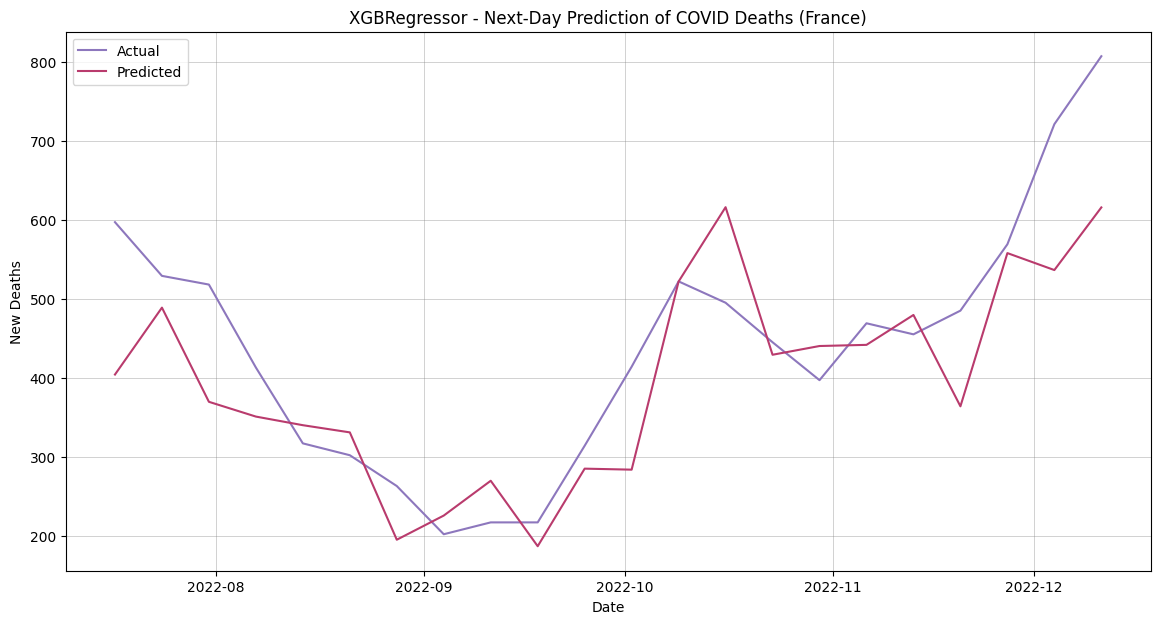

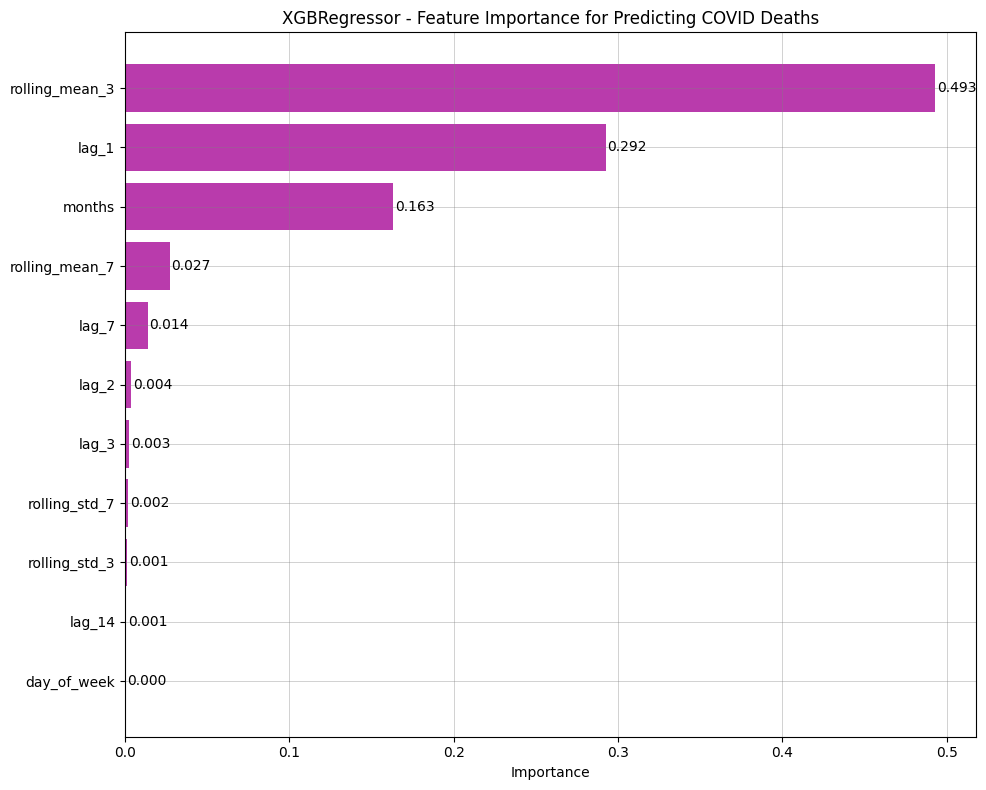

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [21]:
evaluate_model(xgb.XGBRegressor(random_state=42), X_train_lags, y_train, X_test_lags, y_test)

## HPO (hyperparameters optimization) with Optuna

### RF

In [22]:
import optuna

### HPO (hyperparameters optimization) with Optuna
def objective(trial):
    # Hyperparameters to tune
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)

    # Create the model with the suggested hyperparameters
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    model.fit(X_train_lags, y_train['target_t_plus'])
    y_pred = model.predict(X_test_lags)

    # Evaluation on test set
    rmse_test = root_mean_squared_error(y_test['target_t_plus'], y_pred)
    return rmse_test

study = optuna.create_study()
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print(trial.params)


[I 2025-10-01 01:24:23,753] A new study created in memory with name: no-name-09cd886f-7a25-4c91-9f31-45d7be41b46d
[I 2025-10-01 01:24:24,026] Trial 0 finished with value: 152.50753285359838 and parameters: {'n_estimators': 620, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 0 with value: 152.50753285359838.
[I 2025-10-01 01:24:24,606] Trial 1 finished with value: 137.19613809135103 and parameters: {'n_estimators': 652, 'max_depth': 44, 'min_samples_split': 10, 'min_samples_leaf': 17}. Best is trial 1 with value: 137.19613809135103.
[I 2025-10-01 01:24:24,864] Trial 2 finished with value: 137.8120291600752 and parameters: {'n_estimators': 586, 'max_depth': 47, 'min_samples_split': 7, 'min_samples_leaf': 17}. Best is trial 1 with value: 137.19613809135103.
[I 2025-10-01 01:24:24,910] Trial 3 finished with value: 164.02587946390253 and parameters: {'n_estimators': 119, 'max_depth': 47, 'min_samples_split': 9, 'min_samples_leaf': 20}. Best is trial 1 with val

Best trial:
  Value: 126.84077577606902
{'n_estimators': 690, 'max_depth': 30, 'min_samples_split': 12, 'min_samples_leaf': 14}


RandomForestRegressor - RMSE for each split: [2102.32307937  625.46230519  340.83868843]
RandomForestRegressor - Mean RMSE: 1022.8747
RandomForestRegressor Test Set -> RMSE: 126.8408


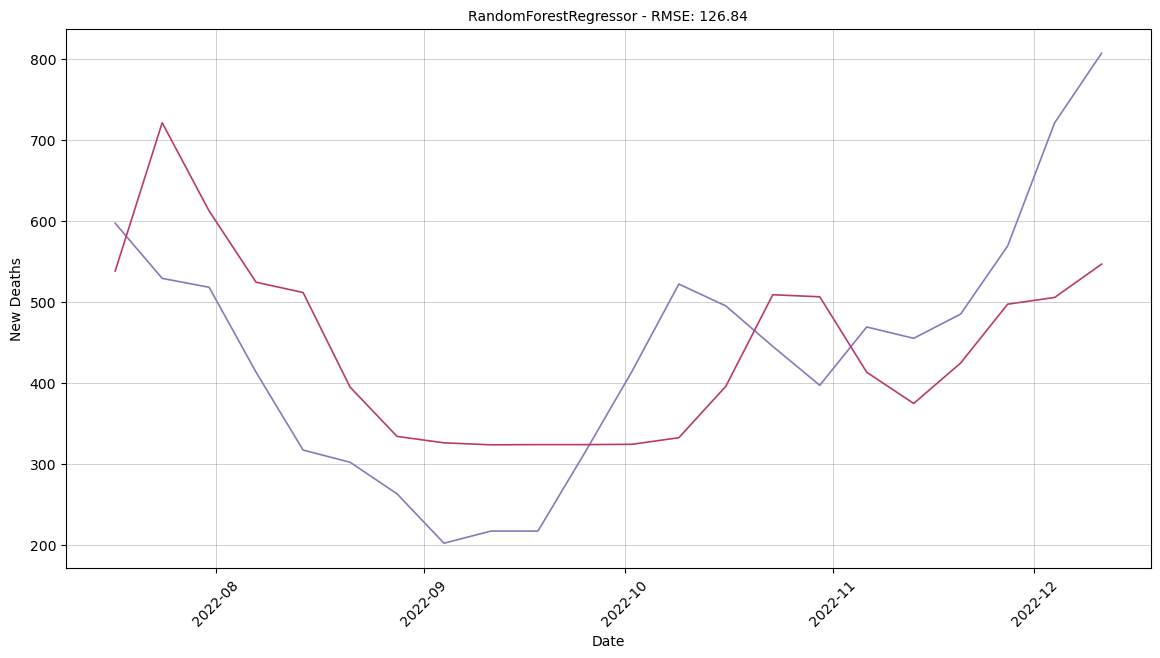

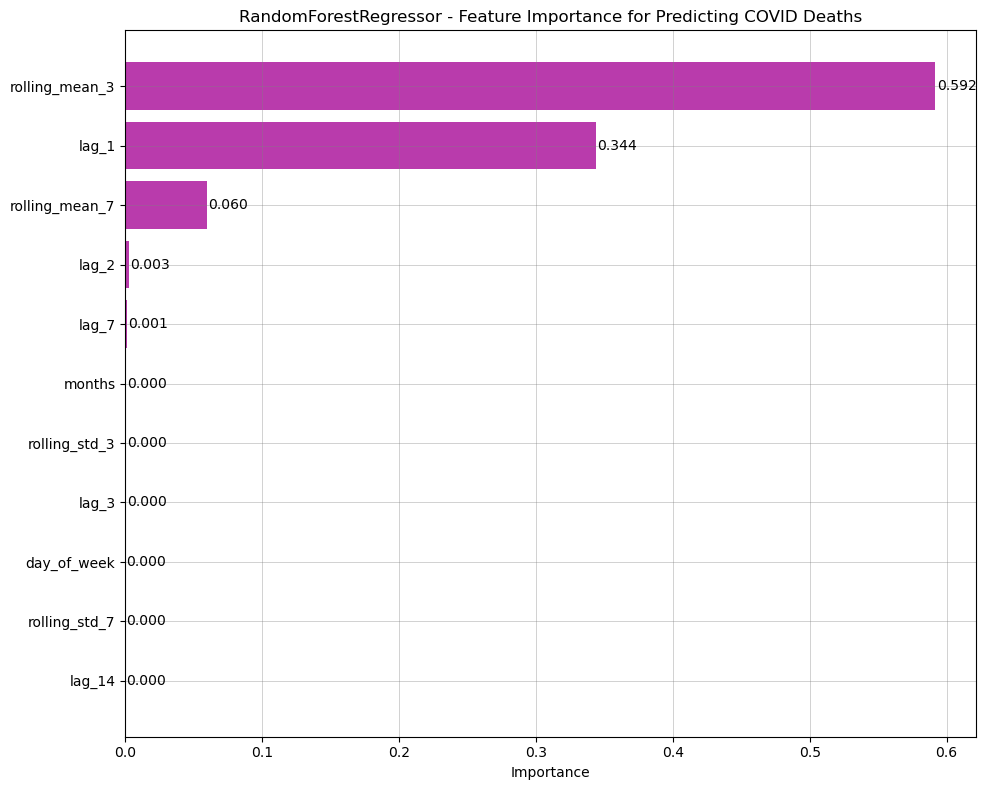

In [16]:
param ={'n_estimators': 690, 'max_depth': 30, 'min_samples_split': 12, 'min_samples_leaf': 14}


rf_model = RandomForestRegressor(
    n_estimators=param['n_estimators'],
    max_depth=param['max_depth'],
    min_samples_split=param['min_samples_split'],
    min_samples_leaf=param['min_samples_leaf'],
    random_state=42
)

model_france = evaluate_model(rf_model, X_train_lags, y_train, X_test_lags, y_test)

### XGBoost

In [25]:
import optuna

def objective(trial):
    # Hyperparameters to tune (valid for XGBRegressor)
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 3, 12)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    gamma = trial.suggest_float('gamma', 0, 5)

    # Create the model
    model = xgb.XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        random_state=42,
        objective='reg:squarederror',
        n_jobs=-1
    )
    
    model.fit(X_train_lags, y_train['target_t_plus'])
    y_pred = model.predict(X_test_lags)

    # Evaluation on test set
    rmse_test = root_mean_squared_error(y_test['target_t_plus'], y_pred)
    return rmse_test
    
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
print(trial.params)


[I 2025-10-01 01:26:31,005] A new study created in memory with name: no-name-47a4c509-9289-46ab-8f7c-ab736e48741d
[I 2025-10-01 01:26:31,279] Trial 0 finished with value: 98.51126310513015 and parameters: {'n_estimators': 331, 'max_depth': 6, 'learning_rate': 0.1196138723875027, 'subsample': 0.5388020734773198, 'colsample_bytree': 0.5608185340508214, 'gamma': 0.6146394171251085}. Best is trial 0 with value: 98.51126310513015.
[I 2025-10-01 01:26:31,407] Trial 1 finished with value: 99.68216283236019 and parameters: {'n_estimators': 151, 'max_depth': 5, 'learning_rate': 0.017401859775193287, 'subsample': 0.6137618888472863, 'colsample_bytree': 0.951385974194382, 'gamma': 1.6429421069480514}. Best is trial 0 with value: 98.51126310513015.
[I 2025-10-01 01:26:32,721] Trial 2 finished with value: 89.11147800243019 and parameters: {'n_estimators': 781, 'max_depth': 10, 'learning_rate': 0.011107622541118575, 'subsample': 0.7266739814603673, 'colsample_bytree': 0.912890588844576, 'gamma': 2.0

Best trial:
  Value: 72.5808923721065
  Params: 
{'n_estimators': 864, 'max_depth': 4, 'learning_rate': 0.05013452514892343, 'subsample': 0.9179138541118652, 'colsample_bytree': 0.9811899903007336, 'gamma': 0.05304913087404062}


XGBRegressor - RMSE for each split: [1582.89844505  600.70467894  357.83256258]
XGBRegressor - Mean RMSE: 847.1452
XGBRegressor Test Set -> RMSE: 72.5809


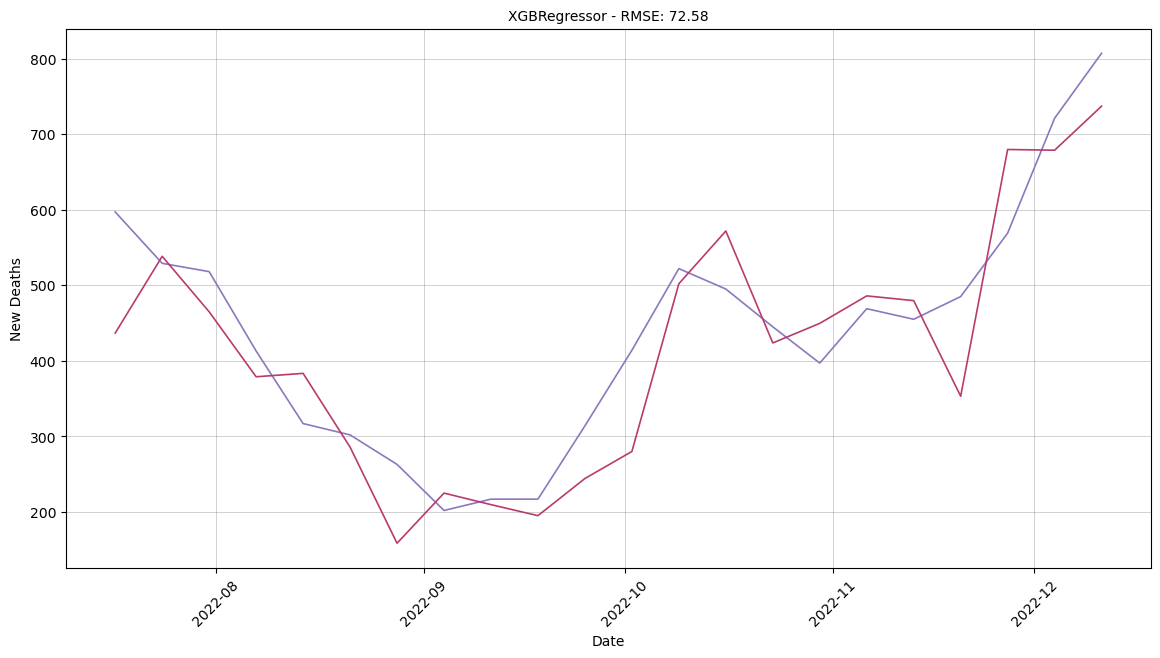

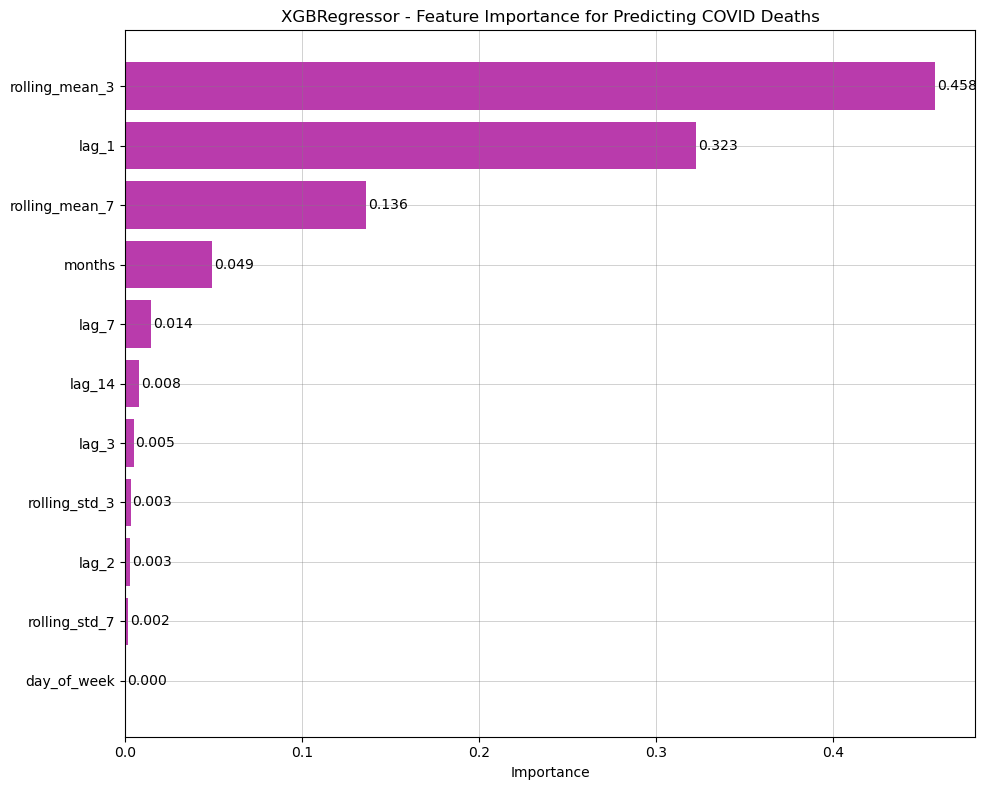

In [17]:
param = {'n_estimators': 864, 'max_depth': 4, 'learning_rate': 0.05013452514892343, 'subsample': 0.9179138541118652, 'colsample_bytree': 0.9811899903007336, 'gamma': 0.05304913087404062}

xgb_france_model = xgb.XGBRegressor(
    n_estimators=param['n_estimators'],
    max_depth=param['max_depth'],
    learning_rate=param['learning_rate'],
    subsample=param['subsample'],
    colsample_bytree=param['colsample_bytree'],
    gamma=param['gamma'],
    random_state=42,
    objective='reg:squarederror',
    n_jobs=-1
)

model_france = evaluate_model(xgb_france_model, X_train_lags, y_train, X_test_lags, y_test)

In [27]:
import optuna

def objective(trial):
    # Hyperparameters to tune (valid for XGBRegressor)
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 3, 12)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    gamma = trial.suggest_float('gamma', 0, 5)

    # Create the model
    model = xgb.XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        random_state=42,
        objective='reg:squarederror',
        n_jobs=-1
    )
    
    model.fit(X_train, y_train['target_t_plus'])
    y_pred = model.predict(X_test)

    # Evaluation on test set
    rmse_test = root_mean_squared_error(y_test['target_t_plus'], y_pred)
    return rmse_test
    
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
print(trial.params)


[I 2025-10-01 01:27:45,428] A new study created in memory with name: no-name-3d3445b2-2a45-48c8-b708-67f4ffc3b582
[I 2025-10-01 01:27:46,005] Trial 0 finished with value: 128.91528425673485 and parameters: {'n_estimators': 887, 'max_depth': 10, 'learning_rate': 0.06918484543201203, 'subsample': 0.5869090452359124, 'colsample_bytree': 0.8513138168508779, 'gamma': 3.5840692047767195}. Best is trial 0 with value: 128.91528425673485.
[I 2025-10-01 01:27:46,222] Trial 1 finished with value: 200.0097230312643 and parameters: {'n_estimators': 209, 'max_depth': 5, 'learning_rate': 0.011357663966929634, 'subsample': 0.8062985136858845, 'colsample_bytree': 0.6824300717335612, 'gamma': 1.564346491197356}. Best is trial 0 with value: 128.91528425673485.
[I 2025-10-01 01:27:46,525] Trial 2 finished with value: 152.57781482992863 and parameters: {'n_estimators': 593, 'max_depth': 5, 'learning_rate': 0.24401251673458768, 'subsample': 0.5227984247247098, 'colsample_bytree': 0.934603708711061, 'gamma':

Best trial:
  Value: 63.04664522930715
  Params: 
{'n_estimators': 113, 'max_depth': 3, 'learning_rate': 0.03694994904996526, 'subsample': 0.6018970961286191, 'colsample_bytree': 0.9060309643938371, 'gamma': 4.062334806790358}


XGBRegressor - RMSE for each split: [1685.60635734  413.10031113  800.53131645]
XGBRegressor - Mean RMSE: 966.4127
XGBRegressor Test Set -> RMSE: 63.0466


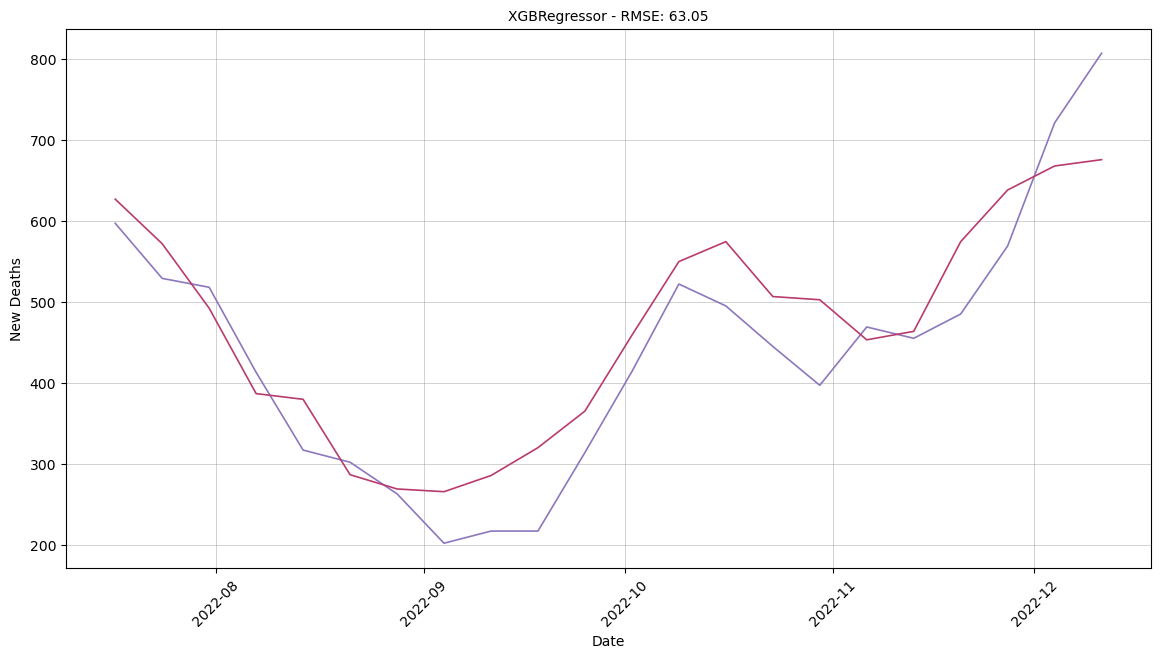

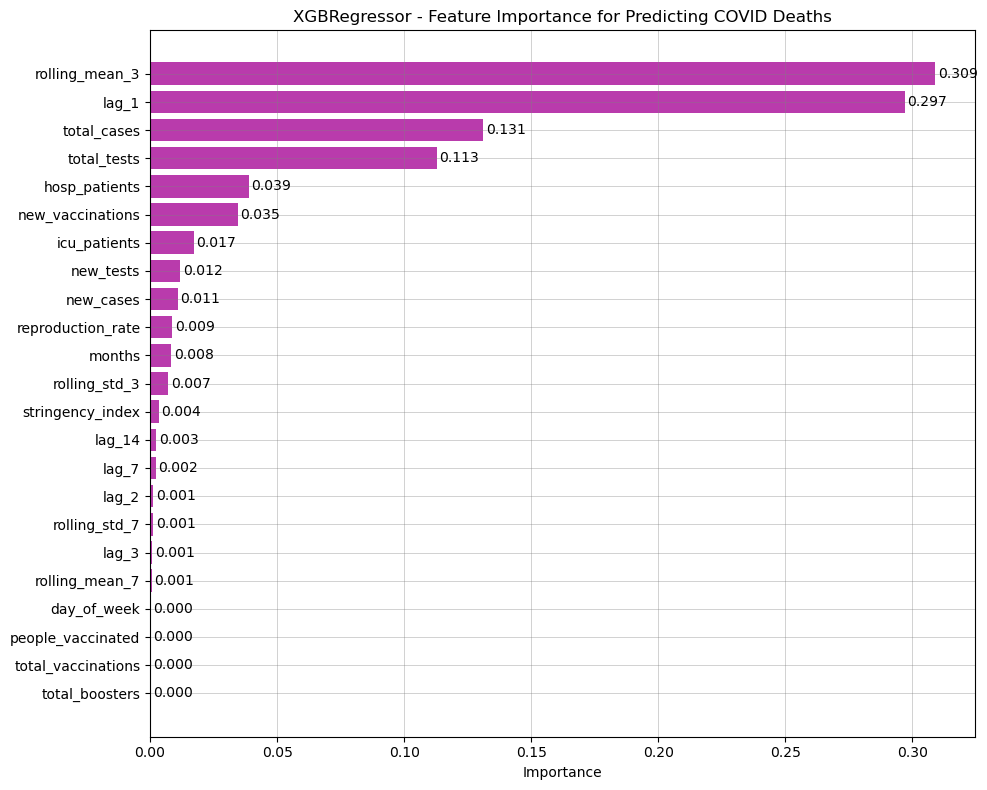

In [18]:
param = {'n_estimators': 113, 'max_depth': 3, 'learning_rate': 0.03694994904996526, 'subsample': 0.6018970961286191, 'colsample_bytree': 0.9060309643938371, 'gamma': 4.062334806790358}

xgb_france_model = xgb.XGBRegressor(
    n_estimators=param['n_estimators'],
    max_depth=param['max_depth'],
    learning_rate=param['learning_rate'],
    subsample=param['subsample'],
    colsample_bytree=param['colsample_bytree'],
    gamma=param['gamma'],
    random_state=42,
    objective='reg:squarederror',
    n_jobs=-1
)

model_france = evaluate_model(xgb_france_model, X_train, y_train, X_test, y_test)

## Generalisation

In [36]:
df_europe.country.unique()

array(['Austria', 'Belarus', 'Belgium', 'Bosnia and Herzegovina',
       'Bulgaria', 'Croatia', 'Cyprus', 'Denmark', 'Estonia', 'Finland',
       'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland',
       'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Moldova',
       'Montenegro', 'Netherlands', 'Norway', 'Poland', 'Portugal',
       'Romania', 'Serbia', 'Slovakia', 'Slovenia', 'Spain', 'Sweden',
       'Switzerland', 'Ukraine', 'United Kingdom'], dtype=object)

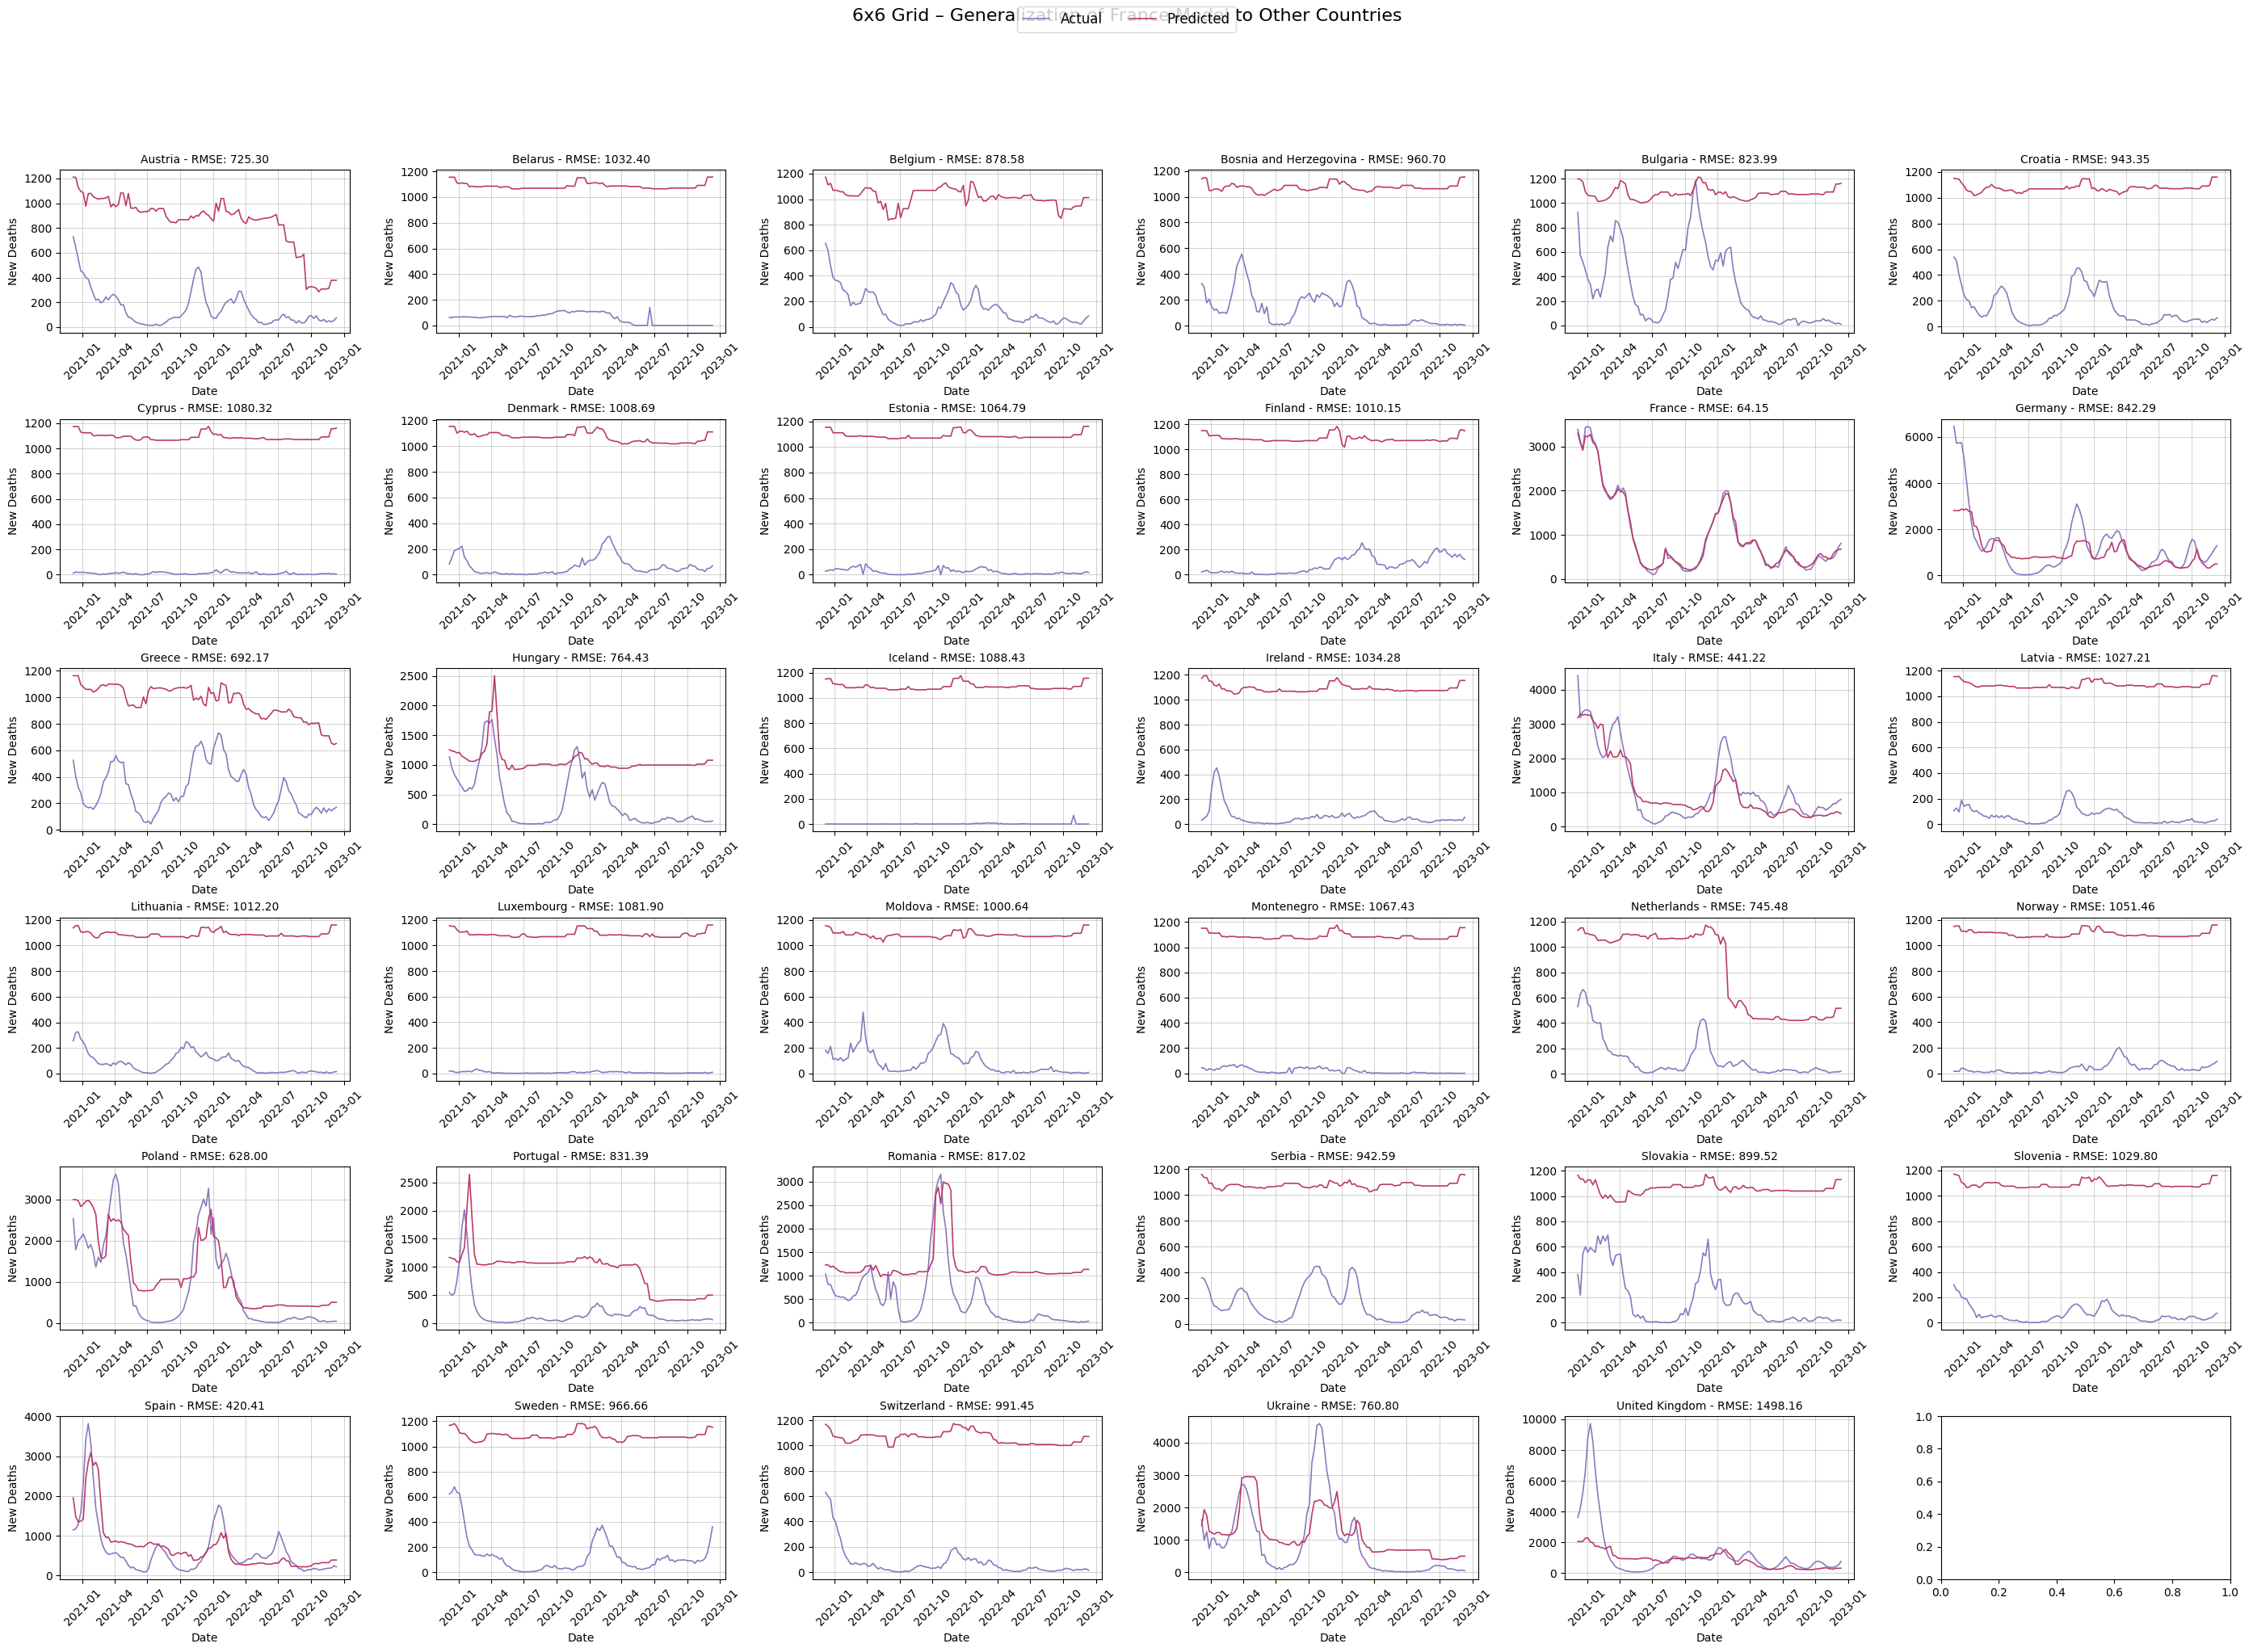

In [ ]:
from sklearn.base import clone

# 6x6 grid setup
fig, axes = plt.subplots(6, 6, figsize=(28, 20), facecolor='white')
axes = axes.flatten()

# Loop through up to 36 countries
for idx, country in enumerate(df_europe.country.unique()):
    if idx >= 36:
        break

    ax = axes[idx]

    # Prepare data for the country
    df_country = feature_processing(country)
    df_model = feature_engineering(df_country)
    df_model = df_model.dropna()

    X = df_model.drop(columns=["date_t_plus", "target_t_plus", "new_deaths"])
    y = df_model[["date_t_plus", "target_t_plus"]]

    # Evaluate with France model, do not retrain
    rmse = evaluate_model(model_france, None, None, X, y, evalutation_only=True, ax=ax, rmse=True)

    # Add country name to title
    ax.set_title(f"{country} - RMSE: {rmse:.2f}", fontsize=10)

# Final layout
plt.tight_layout()
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, ncol=2, fontsize=12)
plt.suptitle("6x6 Grid – Generalization of France Model to Other Countries", fontsize=16, y=1.02)
plt.subplots_adjust(top=0.92)
plt.show()


In [32]:
df_italy = feature_processing('Italy')
df_italy_augmented = feature_engineering(df_italy)

# Supprimer les lignes qui ont des NaN
df_model = df_italy_augmented.dropna()

X_italy = df_model.drop(columns=["date_t_plus","target_t_plus", "new_deaths"])
y_italy = df_model[["date_t_plus", "target_t_plus"]]

XGBRegressor Test Set -> RMSE: 441.2205


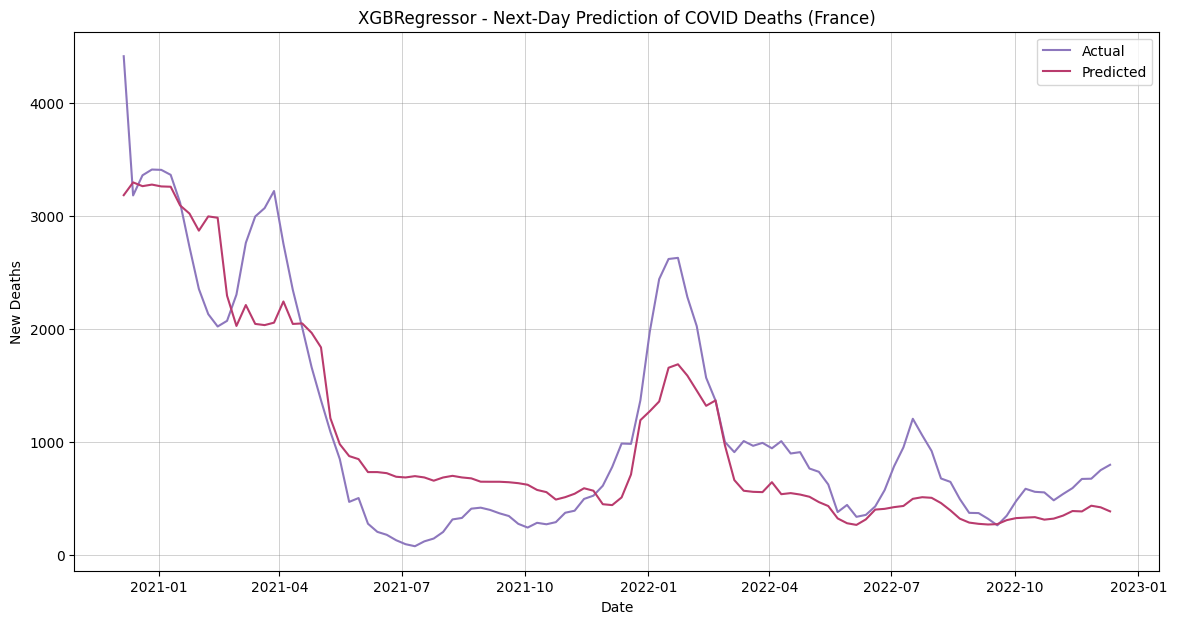

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9060309643938371, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=4.062334806790358, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03694994904996526,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=113, n_jobs=-1,
             num_parallel_tree=None, ...)

In [33]:
evaluate_model(model_france, None, None, X_italy, y_italy, evalutation_only=True)

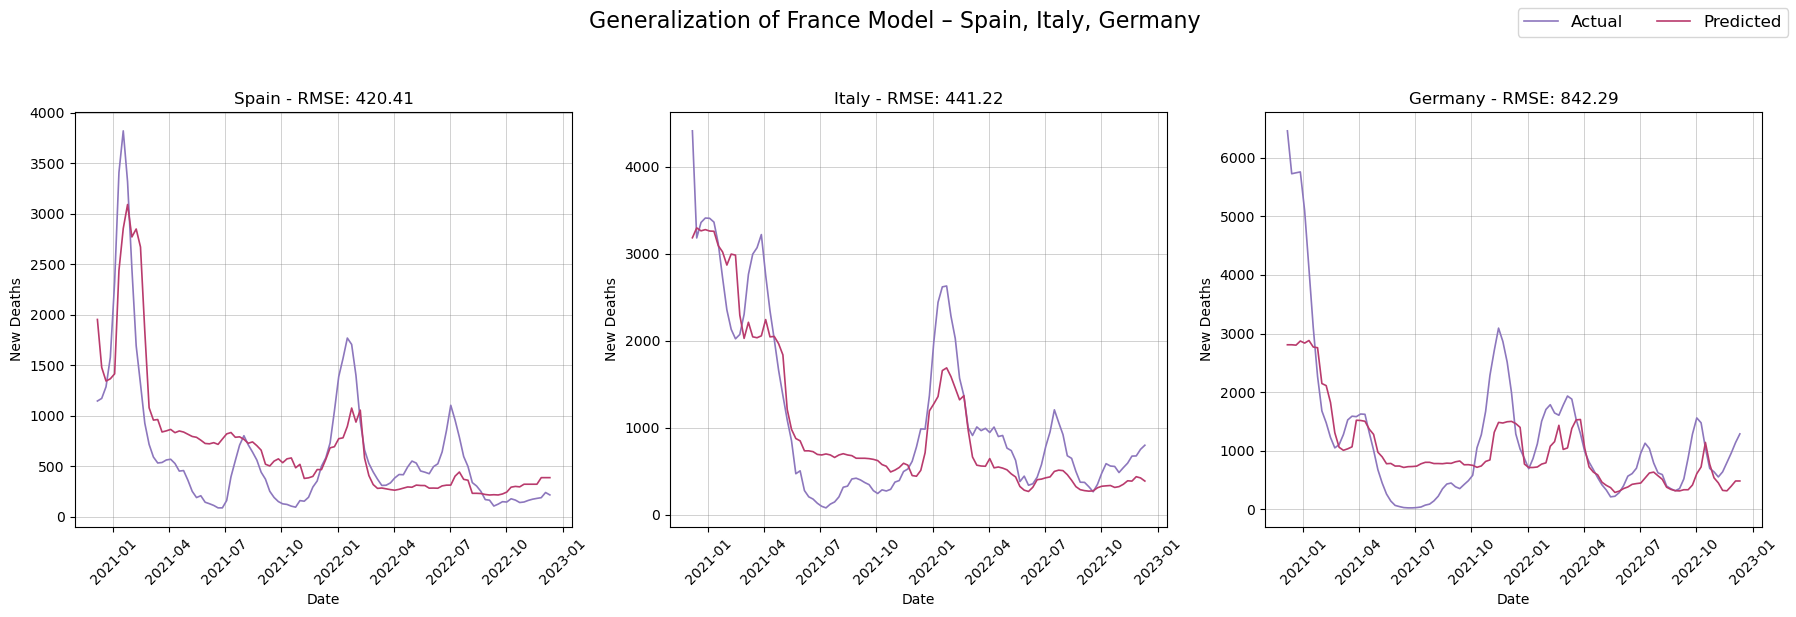

In [19]:
# Liste des pays à afficher
countries = ["Spain", "Italy", "Germany"]

# Grille adaptée (ici 1 ligne, 3 colonnes)
fig, axes = plt.subplots(1, len(countries), figsize=(18, 6), facecolor='white')
if len(countries) == 1:
    axes = [axes]  # si un seul pays, garder liste pour uniformiser

# Boucle sur les pays choisis
for idx, country in enumerate(countries):
    ax = axes[idx]

    # Préparation des données pour le pays
    df_country = feature_processing(country)
    df_model = feature_engineering(df_country)
    df_model = df_model.dropna()

    X = df_model.drop(columns=["date_t_plus", "target_t_plus", "new_deaths"])
    y = df_model[["date_t_plus", "target_t_plus"]]

    # Évaluation avec le modèle de la France (sans réentraînement)
    rmse = evaluate_model(model_france, None, None, X, y, evalutation_only=True, ax=ax, rmse=True)

    # Ajout du titre
    ax.set_title(f"{country} - RMSE: {rmse:.2f}", fontsize=12)

# Mise en page finale
plt.tight_layout()
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, ncol=2, fontsize=12)
plt.suptitle("Generalization of France Model – Spain, Italy, Germany", fontsize=16, y=1.02)
plt.subplots_adjust(top=0.85)
plt.show()
